In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import imageio
from pathlib import Path
from time import strftime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, models, regularizers
from itertools import cycle


In [2]:
# Define constants
RANDOM_SEED = 42
WIDTH, HEIGHT = 224, 224
INPUT_SHAPE = (WIDTH, HEIGHT, 3)

## Data exploration

### Load data

In [8]:
future_data = pd.read_csv('future_data_2024.csv')
development_data = pd.read_csv('train_data_2024.csv')

In [9]:
future_data.head()

,FileName
0,Img_1963.jpg
1,Img_7244.jpg
2,Img_6218.jpg
3,Img_7703.jpg
4,Img_6318.jpg


In [10]:
development_data.head()

,FileName,Class,MoreThanOnePerson,HighLevelCategory
0,Img_460.jpg,blowing_bubbles,YES,Social_LeisureActivities
1,Img_8152.jpg,blowing_bubbles,YES,Social_LeisureActivities
2,Img_9056.jpg,jumping,YES,Sports_Recreation
3,Img_3880.jpg,pushing_a_cart,YES,OutdoorActivities
4,Img_3168.jpg,writing_on_a_book,NO,Artistic_MusicalActivities


As we can see, the development data has 3 labels, excluding FileName. We only need to predict the Class and MoreThanOnePerson label. That leaves the HighLevelCategory with no use. However, we could possibly use HighLevelCategory for an aux output layer to help normalize the model if needed

In [11]:
# Validation, check if the data is the same as the assignment description
development_data['Class'].nunique()

40

In [12]:
development_data['FileName'].count()

4500

It seems that future_data does not contain any labels, so we can't use it for evaluation. Therefore, the data from train_data_2024.csv file (development data) will be split into training, testing and validation data. Additionally, development data has the correct number of unique classes as specified in the assignment specification

### Validate images

In this step, we check the detail of the images and validate if there are any missing images from the dataset. If there are, we need to remove the record from the dataframe or there will be problem loading the image data during training. Additionally, since we want the future data to be independent from the training data, we need to check if there are any overlapping image records in the dataframe

In [8]:
# Check if any FileName in train_data also appear in future_data
# Because we want the data to be independent
development_data['FileName'].isin(future_data['FileName']).sum()

0

In [18]:
# Check the size of images
def get_image_size(filepath):
    im = imageio.imread(filepath)
    return im.shape[1], im.shape[0]

def check_images_size(data):
    # List to store the sizes of the images
    sizes = []

    # Iterate through each filename in data['FileName']
    for filename in data['FileName']:
        path = os.path.join('Images', filename)
        # Get the size of the image
        print(path)
        size = get_image_size(path)
        sizes.append(size)

    return sizes

In [19]:
sizes = check_images_size(development_data)

Images\Img_460.jpg
Images\Img_8152.jpg
Images\Img_9056.jpg
Images\Img_3880.jpg
Images\Img_3168.jpg
Images\Img_8609.jpg
Images\Img_3838.jpg
Images\Img_1699.jpg
Images\Img_8543.jpg
Images\Img_1980.jpg
Images\Img_1312.jpg
Images\Img_4514.jpg
Images\Img_3866.jpg
Images\Img_1665.jpg
Images\Img_4231.jpg
Images\Img_8675.jpg
Images\Img_1137.jpg
Images\Img_5918.jpg
Images\Img_951.jpg
Images\Img_5516.jpg
Images\Img_8478.jpg
Images\Img_5152.jpg
Images\Img_2000.jpg
Images\Img_8656.jpg
Images\Img_5416.jpg
Images\Img_4513.jpg
Images\Img_1342.jpg
Images\Img_6016.jpg
Images\Img_7130.jpg
Images\Img_5929.jpg
Images\Img_911.jpg
Images\Img_2077.jpg
Images\Img_949.jpg
Images\Img_997.jpg
Images\Img_991.jpg
Images\Img_4408.jpg
Images\Img_3907.jpg
Images\Img_3098.jpg
Images\Img_7745.jpg
Images\Img_9239.jpg
Images\Img_1290.jpg
Images\Img_1018.jpg
Images\Img_5533.jpg
Images\Img_793.jpg
Images\Img_8428.jpg
Images\Img_2875.jpg
Images\Img_3195.jpg
Images\Img_2888.jpg
Images\Img_2537.jpg
Images\Img_6433.jpg
Images\

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_23124\2312564628.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(filepath)


Images\Img_7388.jpg
Images\Img_3003.jpg
Images\Img_2954.jpg
Images\Img_5722.jpg
Images\Img_805.jpg
Images\Img_6101.jpg
Images\Img_310.jpg
Images\Img_6.jpg
Images\Img_5420.jpg
Images\Img_297.jpg
Images\Img_3282.jpg
Images\Img_1976.jpg
Images\Img_9230.jpg
Images\Img_6052.jpg
Images\Img_6179.jpg
Images\Img_3330.jpg
Images\Img_7308.jpg
Images\Img_2997.jpg
Images\Img_7335.jpg
Images\Img_3346.jpg
Images\Img_5807.jpg
Images\Img_7114.jpg
Images\Img_601.jpg
Images\Img_3946.jpg
Images\Img_6979.jpg
Images\Img_4523.jpg
Images\Img_350.jpg
Images\Img_8600.jpg
Images\Img_2996.jpg
Images\Img_2845.jpg
Images\Img_7993.jpg
Images\Img_8009.jpg
Images\Img_7789.jpg
Images\Img_7978.jpg
Images\Img_3515.jpg
Images\Img_7544.jpg
Images\Img_8305.jpg
Images\Img_7225.jpg
Images\Img_8910.jpg
Images\Img_7042.jpg
Images\Img_7753.jpg
Images\Img_5402.jpg
Images\Img_2935.jpg
Images\Img_829.jpg
Images\Img_9068.jpg
Images\Img_4511.jpg
Images\Img_2220.jpg
Images\Img_6463.jpg
Images\Img_8826.jpg
Images\Img_4842.jpg
Images\Im

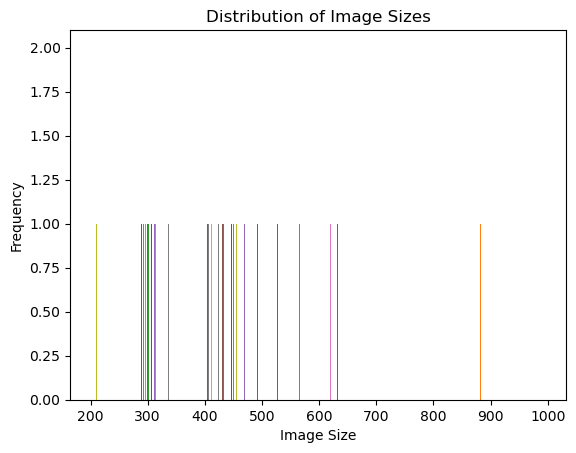

In [20]:
# Plot the sizes
plt.hist(sizes, bins=20)
plt.xlabel('Image Size')
plt.ylabel('Frequency')
plt.title('Distribution of Image Sizes')
plt.show()

From the analysis, there are no file label in development data overlapped with future data, this means that when loading the images, the development data is independent from future data. Additionally, no image is missing from the Image folder after unzip. Finally, since the images have different sizes, we need to resize them into an uniform size before feeding the data into the model

### Check for data imbalance

<Axes: xlabel='HighLevelCategory'>

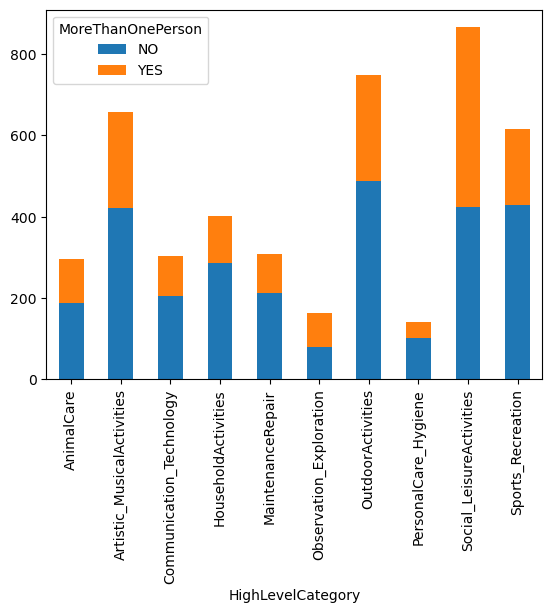

In [21]:
crosstab = pd.crosstab(development_data['HighLevelCategory'], development_data['MoreThanOnePerson'])
crosstab.plot(kind='bar', stacked=True)

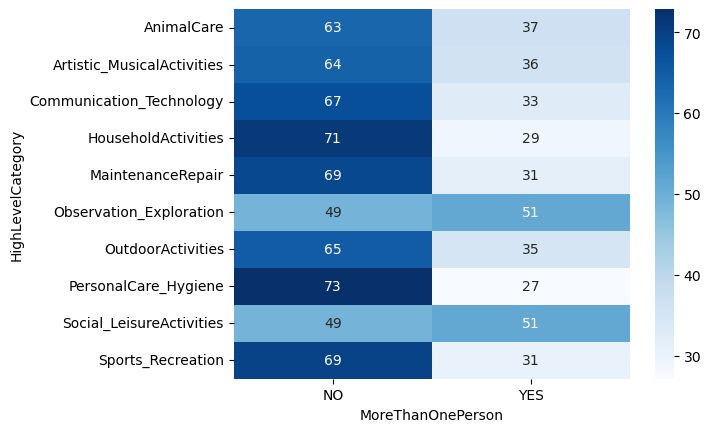

In [22]:
crosstab_percentage = crosstab.div(crosstab.sum(axis=1), axis=0) * 100
sns.heatmap(crosstab_percentage, annot=True, cmap='Blues')
plt.show()

We can see that the MoreThanOnePerson occurence for images in each Class is not balanced, and the occurance for each class is not balanced. Additionally, HighLevelCategory is also imbalanced as well. To solve these problems, we might apply:
- Data synthetic: We can create more data from the existing images so that the occurences in each classes is balanced. However, we also need to ensure that the distribution of MoreThanOnePerson label is still, and this approach can be time consuming
- We could also apply more weight to under-represented classes, or less weight to over-represented classes
- Use transfer learning to reduce overfitting that results from the lack of labeled data

### Prepare data for training

Currently, the data is not suitable for training. The image in the dataframe is only the image file name, while the labels are still strings. Therefore, in this step, we will need to load the images, and encode the labels for training. Additionally, we will only split the data into training and testing, given the dataset's small number of images. 

#### Split data

In [13]:
image_dir = './Images/'

# Get the file paths for each image record
development_data['FilePath'] = development_data['FileName'].apply(lambda x: os.path.join(image_dir, x))
future_data['FilePath'] = future_data['FileName'].apply(lambda x: os.path.join(image_dir, x))

In [14]:
# Currently, the Class and MoreThanOnePerson labels are strings, so we encode them after splitting
class_encoder = LabelEncoder()
development_data['Class'] = class_encoder.fit_transform(development_data['Class'])
development_data['MoreThanOnePerson'] = development_data['MoreThanOnePerson'].map({'YES': 1, 'NO': 0})

In [15]:
# Save the mappings
class_mapping = dict(enumerate(class_encoder.classes_))
binary_mapping = {1: 'YES', 0: 'NO'}

pd.DataFrame(list(class_mapping.items()), columns=['Class Index', 'Class Name']).to_csv('class_mapping.csv', index=False)

In [67]:
def load_image(filepath, label=None, augment=False):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [WIDTH, HEIGHT]) 
    
    if augment:
        image = tf.image.random_flip_left_right(image)
        # Random rotation and brightness, contrast
        image = tf.image.random_brightness(image, 0.5)
        image = tf.image.random_contrast(image, 0.8, 1.3)
    
    image = tf.image.convert_image_dtype(image, tf.float32) / 255.0  # Convert to [0, 1] float range
    image = tf.clip_by_value(image, 0.0, 1.0)  # Ensure pixel values are in [0, 1] range

    if label is None:
        return image
    else: 
        return image, label


In [17]:
# Split data
train, test = train_test_split(development_data, test_size=0.2, random_state=RANDOM_SEED, stratify=development_data['Class'])

In [18]:
len(train), len(test)

(3600, 900)

<Axes: xlabel='Class'>

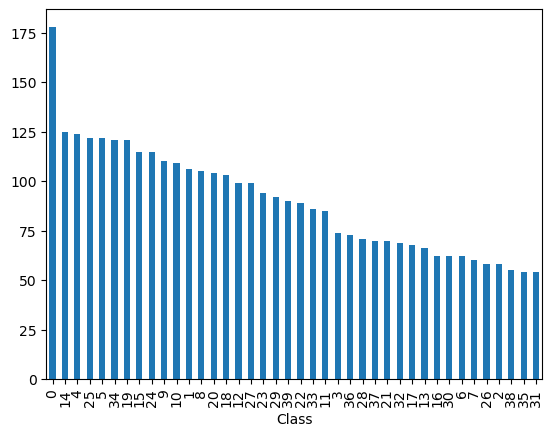

In [19]:
# Check if the distribution of the training data and testing data
train['Class'].value_counts().plot(kind='bar')

<Axes: xlabel='Class'>

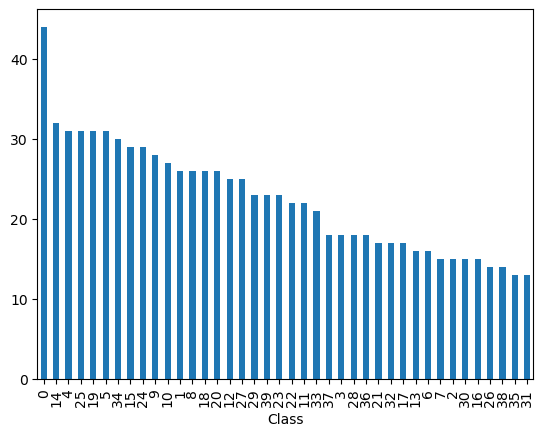

In [20]:
test['Class'].value_counts().plot(kind='bar')

In [21]:
# Loading images and shuffling datasets
train_ds = tf.data.Dataset.from_tensor_slices((train['FilePath'], {'categorical_output': train['Class'], 'binary_output': train['MoreThanOnePerson']}))
train_ds = train_ds.map(lambda x, y: load_image(x, y)).shuffle(1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test['FilePath'], {'categorical_output': test['Class'], 'binary_output': test['MoreThanOnePerson']}))
test_ds = test_ds.map(lambda x, y: load_image(x, y)).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

future_ds = tf.data.Dataset.from_tensor_slices((future_data['FilePath']))
future_ds = future_ds.map(lambda x: load_image(x, None)).shuffle(1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

#### Visualize and validate dataset

(32, 224, 224, 3)
(32,)
(32,)


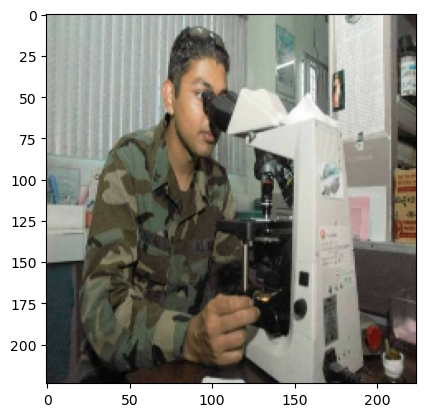

In [22]:
# Validate if the images are loaded correctly
for image, label in test_ds.take(1):
    print(image.shape)
    print(label['categorical_output'].shape)
    print(label['binary_output'].shape)
    plt.imshow(image[0])

(32, 224, 224, 3)
(32,)
(32,)


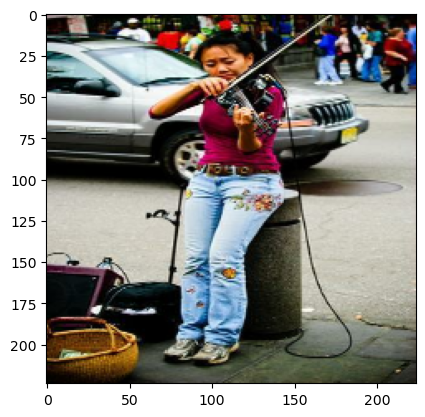

In [23]:
for image, label in train_ds.take(1):
    print(image.shape)
    print(label['categorical_output'].shape)
    print(label['binary_output'].shape)
    plt.imshow(image[0])

(32, 224, 224, 3)


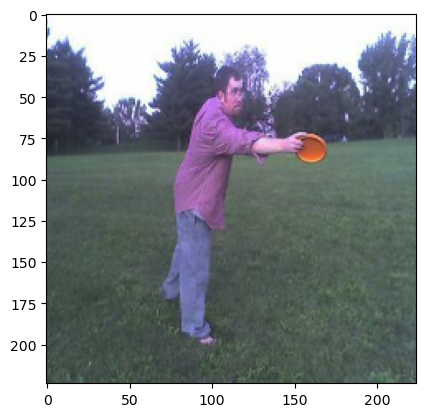

In [24]:
for image in future_ds.take(1):    
    print(image.shape)
    plt.imshow(image[0])

With this, we have split the original development data into training/validation/testing set. We also resized the images into an uniform image size to feed into the model and one hot encode the labels for training. Additionally, we convert the data into a format suitable for inference (tf.data.Dataset) and validate the conversion to ensurre the format is correct. Finally, as we can see from the plots, it seems the data is loaded correctly as the image and label matches each other

## Baseline model

### Helper functions

In [25]:
# Helper function to redefine callbacks
def get_cbs(cbs=[]):
  res_cbs = []
  for cb in cbs:
    res_cbs.append(cb)

  early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
  res_cbs.append(early_stopping_cb)
  
  return res_cbs

In [26]:
def plot_history(history):
    epochs = range(1, len(history.history['loss']) + 1)
    
    # Create subplots
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Plot loss for Class output
    axs[0, 0].plot(epochs, history.history['categorical_output_loss'], label='Training Loss (Class)')
    axs[0, 0].plot(epochs, history.history['val_categorical_output_loss'], label='Validation Loss (Class)')
    axs[0, 0].set_title('Training and Validation Loss (Class Output)')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()

    # Plot loss for Person output
    axs[0, 1].plot(epochs, history.history['binary_output_loss'], label='Training Loss (Person)')
    axs[0, 1].plot(epochs, history.history['val_binary_output_loss'], label='Validation Loss (Person)')
    axs[0, 1].set_title('Training and Validation Loss (Person Output)')
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].legend()
    
    # Plot overall loss
    axs[1, 0].plot(epochs, history.history['loss'], label='Training Loss (Overall)')
    axs[1, 0].plot(epochs, history.history['val_loss'], label='Validation Loss (Overall)')
    axs[1, 0].set_title('Training and Validation Loss (Overall)')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('Loss')
    axs[1, 0].legend()

    # Remove the fourth subplot (bottom-right corner) if not needed
    fig.delaxes(axs[1, 1])

    # Adjust layout
    plt.tight_layout()
    plt.show()


In [27]:
# Function to visualize model's predictions on the dataset
def visualize_dev_preds(model, ds, class_mapping):
    image_batch, label_batch = next(iter(ds))
    preds = model.predict(image_batch)

    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy())
        label1 = tf.argmax(preds[0][i])
        label2 = preds[1][i]
        
        if label2 > 0.5:
            label2 = "YES"
        else:
            label2 = "NO"
        
        plt.title(f'{class_mapping[label1.numpy()]} | {label2}')
        plt.axis("off")

In [28]:
# Function to visualize model's predictions on future_dataset
def visualize_future_preds(model, class_mapping):
    image_batch = next(iter(future_ds))
    preds = model.predict(image_batch)

    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy())
        label1 = tf.argmax(preds[0][i])
        label2 = preds[1][i]
        
        if label2 > 0.5:
            label2 = "YES"
        else:
            label2 = "NO"
        
        plt.title(f'{class_mapping[label1.numpy()]} | {label2}')
        plt.axis("off")

In [29]:
def heatmap(model, dataset, class_mapping):
    true_labels = []
    true_more_than_one_person = []
    predicted_classes = []
    predicted_more_than_one_person = []

    # Iterate over the entire dataset and collect true and predicted labels
    for images, labels in dataset:
        true_labels.extend(labels['categorical_output'].numpy())  # True class labels
        true_more_than_one_person.extend(labels['binary_output'].numpy())  # True more-than-one-person labels
        prediction = model.predict(images, verbose=False)
        predicted_classes.extend(tf.argmax(prediction[0], axis=1).numpy())
        predicted_more_than_one_person.extend([1 if x >= 0.5 else 0 for x in prediction[1]])

    # Create a figure with 1 row and 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(14, 8))

    # Confusion matrix for class predictions
    conf_matrix_class = confusion_matrix(true_labels, predicted_classes)
    
    # Convert class_mapping dictionary to lists of class names sorted by class index
    class_labels = [class_mapping[i] for i in range(len(class_mapping))]

    # Plot the heatmap with class names
    sns.heatmap(conf_matrix_class, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels, yticklabels=class_labels, ax=axes[0])
    axes[0].set_title('Confusion Matrix for Class Predictions')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # Confusion matrix for MoreThanOnePerson predictions
    conf_matrix_person = confusion_matrix(true_more_than_one_person, predicted_more_than_one_person)
    sns.heatmap(conf_matrix_person, annot=True, fmt='d', cmap='Blues',
                xticklabels=["NO", "YES"], yticklabels=["NO", "YES"], ax=axes[1])
    axes[1].set_title('Confusion Matrix for MoreThanOnePerson Predictions')
    axes[1].set_ylabel('True Label')
    axes[1].set_xlabel('Predicted Label')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

### Create baseline models

The baseline model is designed based on the CNN architecture used for real-time Human Activity Recognition (HAR) as outlined in [this paper](https://link.springer.com/article/10.1007/s11036-019-01445-x), with significant modifications to better align with our specific problem requirements.

**Model Outputs and Activation Functions**:

While the original model features a single output layer, the task requires predicting two distinct labels: Class and MoreThanOnePerson. To accommodate this, the model is designed with two separate output layers. The first output layer, responsible for classifying 40 different classes under the Class label, includes 40 neurons with a softmax activation function, ideal for multi-class classification. The second output layer, tasked with binary classification for the MoreThanOnePerson label, consists of a single neuron with a sigmoid activation function.

**Loss Functions**:

Given that the Class label is categorical and not one-hot encoded, I use the sparse categorical crossentropy loss function for the first output. For the binary MoreThanOnePerson label, I use binary crossentropy, which is well-suited for binary classification tasks. These choices ensure that the loss functions are appropriately matched to the nature of the output labels, enhancing the model’s predictive performance.

**Model Complexity and Flexibility**:

To provide more flexibility in improving the model and address the complexity of our problem, I have added additional convolutional blocks and neurons beyond those in the original structure. This increase in model capacity allows for more sophisticated feature extraction, which is crucial given the intricate nature of the data we are working with. The use of common kernel sizes (3x3) and pool sizes (2x2) ensures effective feature detection while maintaining computational efficiency.

**Activation Functions and Optimizer**:

In the absence of specified activation functions for the hidden layers in the original architecture, I chose ReLU (Rectified Linear Unit) due to its advantages in training speed and overall performance. For optimization, I selected the Adam optimizer because of its ability to converge quickly and its reduced need for hyperparameter tuning, making it a practical and efficient choice for our baseline model.

**Metrics**

For evaluating the performance of the model, I selected the following metrics:
- AUC (Area Under the Curve) for the second output (binary classification). AUC is appropriate here because it measures the model's ability to distinguish between the two classes and provides a summary of the model's performance across different threshold values. This is useful for binary classification problems where we want to understand how well the model performs in separating the two classes where data is unbalanced.

- Accuracy for the first output (multi-class classification). Since this output involves predicting one of several classes (40 in total), accuracy is a suitable metric as it simply measures the proportion of correctly predicted classes out of the total predictions. AUC and Precision are not appropriate for this output because both requires one-hot encoded labels



In [57]:
input_layer = layers.Input(shape=INPUT_SHAPE) 

conv_base = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
conv_base = layers.MaxPooling2D((2, 2))(conv_base)
conv_base = layers.Conv2D(64, (3, 3), activation='relu')(conv_base)
conv_base = layers.MaxPooling2D((2, 2))(conv_base)
conv_base = layers.Conv2D(128, (3, 3), activation='relu')(conv_base)
conv_base = layers.MaxPooling2D((2, 2))(conv_base)

flattened = layers.Flatten()(conv_base)
dense_shared = layers.Dense(128, activation='relu')(flattened)

output_categorical = layers.Dense(40, activation='softmax', name='categorical_output')(dense_shared)  

output_binary = layers.Dense(1, activation='sigmoid', name='binary_output')(dense_shared)

baseline_model = models.Model(inputs=input_layer, outputs=[output_categorical, output_binary])

baseline_model.compile(optimizer='adam',
              loss={'categorical_output': 'sparse_categorical_crossentropy',
                    'binary_output': 'binary_crossentropy'},
              metrics={'categorical_output': 'accuracy',
                       'binary_output': tf.keras.metrics.AUC(name='auc')})

baseline_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 222, 222, 32  896         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_9 (MaxPooling2D)  (None, 111, 111, 32  0          ['conv2d_9[0][0]']               
                                )                                                           

In [58]:
history = baseline_model.fit(train_ds, epochs=10, callbacks=get_cbs(), validation_data=test_ds)

Epoch 1/10


113/113 [==============================] - 9s 72ms/step - loss: 4.3509 - categorical_output_loss: 3.6801 - binary_output_loss: 0.6707 - categorical_output_accuracy: 0.0475 - binary_output_auc: 0.5154 - val_loss: 4.2547 - val_categorical_output_loss: 3.6026 - val_binary_output_loss: 0.6521 - val_categorical_output_accuracy: 0.0600 - val_binary_output_auc: 0.5468
Epoch 2/10
113/113 [==============================] - 8s 68ms/step - loss: 4.1723 - categorical_output_loss: 3.5161 - binary_output_loss: 0.6563 - categorical_output_accuracy: 0.0789 - binary_output_auc: 0.5698 - val_loss: 4.1073 - val_categorical_output_loss: 3.4696 - val_binary_output_loss: 0.6377 - val_categorical_output_accuracy: 0.0922 - val_binary_output_auc: 0.6055
Epoch 3/10
113/113 [==============================] - 8s 68ms/step - loss: 3.8274 - categorical_output_loss: 3.2011 - binary_output_loss: 0.6263 - categorical_output_accuracy: 0.1536 - binary_output_auc: 0.6567 - val_loss: 4.1758 - val_categorical_output_loss: 

### Evaluate model

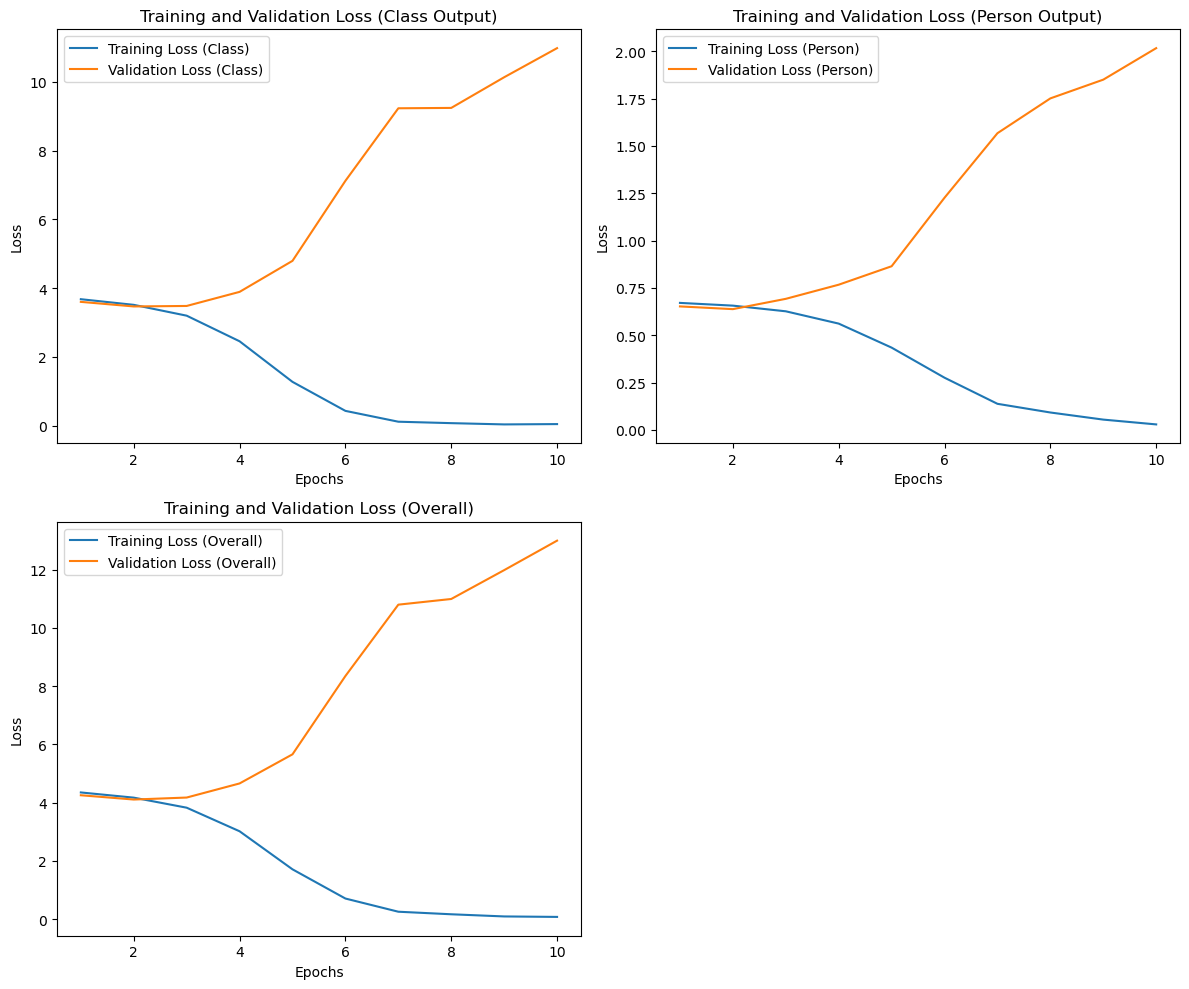

In [59]:
plot_history(history)

The model is clearly overfitting to the training data, which is expected given the small amount of training data available for each class. With such limited data, the model can easily memorize the training set, leading to overfitting. However, there is a possibility that the testing data was loaded incorrectly, which could cause a significant difference between the training and testing data. If this is the case, the model will struggle to perform well on the testing data, regardless of what it has learned from the training data. Therefore, the next step is to thoroughly evaluate the data to ensure there are no issues that could affect the model's performance.

### Validate training and prediction data

In [44]:
# Function to see the underlying data in the dataset
def validate_ds(ds):
    image_batch, label_batch = next(iter(ds))

    label1 = label_batch['categorical_output'][0]
    label2 = label_batch['binary_output'][0]
    plt.imshow(image_batch[0])
    print(image_batch[0])
    print(label1)
    print(label2)

tf.Tensor(
[[[0.8787124  0.77283007 0.6042026 ]
  [0.8113805  0.70549816 0.53687066]
  [0.83834827 0.7324659  0.5638385 ]
  ...
  [0.77448356 0.7117384  0.62154233]
  [0.77448356 0.7117384  0.62154233]
  [0.77448356 0.7117384  0.62154233]]

 [[0.8723938  0.76651144 0.597884  ]
  [0.8555444  0.74966204 0.5810346 ]
  [0.8652749  0.75939256 0.59076506]
  ...
  [0.77254903 0.70980394 0.61960787]
  [0.77254903 0.70980394 0.61960787]
  [0.77254903 0.70980394 0.61960787]]

 [[0.86878484 0.7629025  0.594275  ]
  [0.9123028  0.80642045 0.63779294]
  [0.83869046 0.7328081  0.5641807 ]
  ...
  [0.7647059  0.7058824  0.6156863 ]
  [0.7647059  0.7058824  0.6156863 ]
  [0.7647059  0.7058824  0.6156863 ]]

 ...

 [[0.21039039 0.14372371 0.10450803]
  [0.21860342 0.15193674 0.11272106]
  [0.22952352 0.16285686 0.12364119]
  ...
  [0.25073662 0.18799153 0.12524642]
  [0.2766127  0.2138676  0.15112251]
  [0.23809946 0.17535436 0.11260927]]

 [[0.2146963  0.152113   0.12129195]
  [0.2260765  0.16505593 0

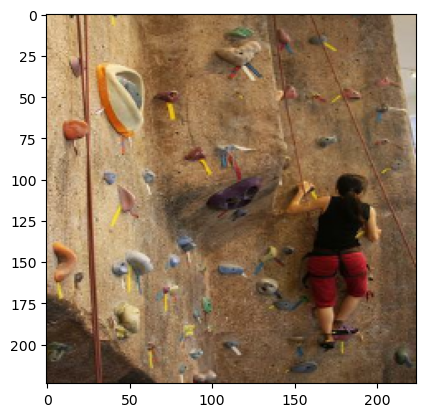

In [45]:
validate_ds(train_ds)

tf.Tensor(
[[[0.6608456  0.7175245  0.6803309 ]
  [0.6709559  0.7119485  0.68057597]
  [0.6676908  0.6906075  0.66542363]
  ...
  [0.1882353  0.15686275 0.14901961]
  [0.1801383  0.14876576 0.14092262]
  [0.20049895 0.16912639 0.16128325]]

 [[0.6627538  0.70967263 0.6764093 ]
  [0.6670343  0.70802695 0.6766544 ]
  [0.6814962  0.7115174  0.6832097 ]
  ...
  [0.19012605 0.1587535  0.15091036]
  [0.19621848 0.16484593 0.15700279]
  [0.19607843 0.16470589 0.15686275]]

 [[0.6646446  0.7038603  0.67248774]
  [0.6648897  0.7041054  0.67273283]
  [0.6655714  0.7047871  0.6734145 ]
  ...
  [0.18552281 0.15415026 0.14630713]
  [0.19507179 0.16369924 0.1558561 ]
  [0.17496827 0.14359573 0.13575259]]

 ...

 [[0.12913717 0.14757761 0.16328795]
  [0.12869512 0.14711148 0.16286996]
  [0.14858073 0.16697304 0.18277967]
  ...
  [0.17193627 0.12532274 0.12443215]
  [0.18407725 0.14841548 0.14094   ]
  [0.16665757 0.13528502 0.12352031]]

 [[0.12857656 0.1481844  0.16387068]
  [0.12869474 0.14830258 0

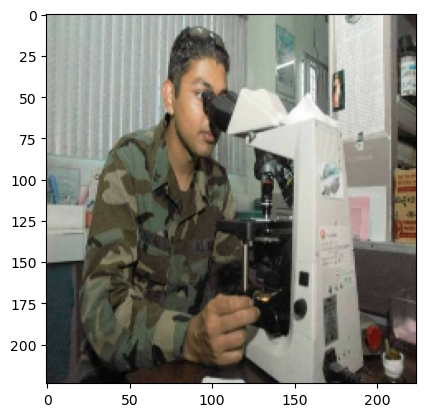

In [46]:
validate_ds(test_ds)

It appears that the data is fine, so the issue is likely due to overfitting in the model. To address this, the next step will be to enhance the model by introducing regularization techniques.

## Model Regularization

#### Apply well-known regularization methods

To regularize the baseline model, we will alter the model's architecture by several well-established regularization techniques such as Dropout, Batch Normalization, L2 regularizations to see if these techniques have any effect on the model's overfitting problem. The effectiveness of these techniques have been proven in these papers:
- [Dropout](https://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf)
- [Batch normalization](https://arxiv.org/abs/1502.03167)
- [L2 regularization](https://link.springer.com/article/10.1007/BF00118728)

In [48]:
# Define the model
input_layer = layers.Input(shape=INPUT_SHAPE)

# Convolutional base
conv_base = layers.Conv2D(32, (3, 3), activation=None, kernel_regularizer=regularizers.l2(0.01))(input_layer)
conv_base = layers.BatchNormalization()(conv_base)
conv_base = layers.ReLU()(conv_base)
conv_base = layers.MaxPooling2D((2, 2))(conv_base)

conv_base = layers.Conv2D(64, (3, 3), activation=None, kernel_regularizer=regularizers.l2(0.01))(conv_base)
conv_base = layers.BatchNormalization()(conv_base)
conv_base = layers.ReLU()(conv_base)
conv_base = layers.MaxPooling2D((2, 2))(conv_base)

conv_base = layers.Conv2D(128, (3, 3), activation=None, kernel_regularizer=regularizers.l2(0.01))(conv_base)
conv_base = layers.BatchNormalization()(conv_base)
conv_base = layers.ReLU()(conv_base)
conv_base = layers.MaxPooling2D((2, 2))(conv_base)

# Flatten and Dense layers
flattened = layers.Flatten()(conv_base)
dense_shared = layers.Dense(128, activation=None, kernel_regularizer=regularizers.l2(0.01))(flattened)
dense_shared = layers.BatchNormalization()(dense_shared)
dense_shared = layers.ReLU()(dense_shared)
dense_shared = layers.Dropout(0.5)(dense_shared)  # Dropout added here

# Output layers
output_categorical = layers.Dense(40, activation='softmax', name='categorical_output')(dense_shared)

output_binary = layers.Dense(1, activation='sigmoid', name='binary_output')(dense_shared)

# Create model
baseline_model = models.Model(inputs=input_layer, outputs=[output_categorical, output_binary])

# Compile model
baseline_model.compile(optimizer='adam',
              loss={'categorical_output': 'sparse_categorical_crossentropy',
                    'binary_output': 'binary_crossentropy'},
              metrics={'categorical_output': 'accuracy',
                       'binary_output': tf.keras.metrics.AUC(name='auc')})

# Model summary
baseline_model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 222, 222, 32  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 222, 222, 32  128        ['conv2d_6[0][0]']               
 rmalization)                   )                                                           

In [49]:
history = baseline_model.fit(train_ds, epochs=10, callbacks=get_cbs(), validation_data=test_ds)

Epoch 1/10
113/113 [==============================] - 24s 119ms/step - loss: 8.7410 - categorical_output_loss: 3.7830 - binary_output_loss: 0.7793 - categorical_output_accuracy: 0.0667 - binary_output_auc: 0.5510 - val_loss: 7.3163 - val_categorical_output_loss: 4.0018 - val_binary_output_loss: 0.8756 - val_categorical_output_accuracy: 0.0244 - val_binary_output_auc: 0.5555
Epoch 2/10
113/113 [==============================] - 13s 115ms/step - loss: 6.2780 - categorical_output_loss: 3.5032 - binary_output_loss: 0.6961 - categorical_output_accuracy: 0.0989 - binary_output_auc: 0.6058 - val_loss: 6.7524 - val_categorical_output_loss: 4.1845 - val_binary_output_loss: 0.7450 - val_categorical_output_accuracy: 0.0233 - val_binary_output_auc: 0.5065
Epoch 3/10
113/113 [==============================] - 13s 115ms/step - loss: 5.8726 - categorical_output_loss: 3.3809 - binary_output_loss: 0.6717 - categorical_output_accuracy: 0.1297 - binary_output_auc: 0.6199 - val_loss: 6.8751 - val_categori

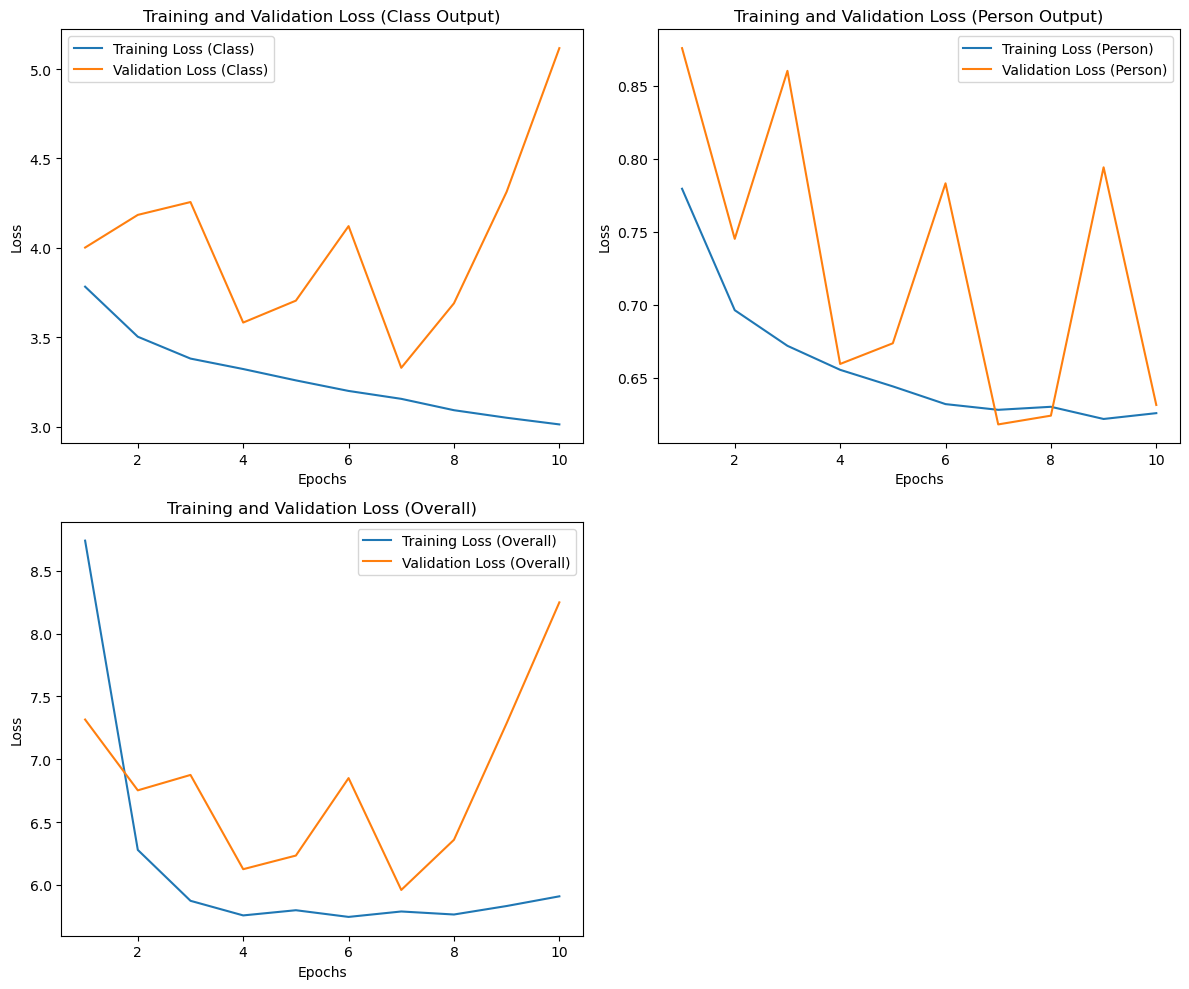

In [56]:
plot_history(history)

Even with well-established regularization techniques, the model is still overfitting significantly, especially on the Class label. This suggests that the current model architecture and the amount of available data are not sufficient for effective learning and generalization.

While generating synthetic data could potentially address the issue by increasing the dataset size, it comes with the risk that the synthetic data might not accurately represent the real-world data, which could negatively impact the model's performance on unseen data.

Given these challenges, I have decided to use transfer learning as a more practical solution. Transfer learning allows us to leverage a pre-trained model that has been trained on a large and diverse dataset. By fine-tuning this model on our specific dataset, we can benefit from the knowledge and features it has already learned, which can help improve performance and reduce overfitting, especially when working with limited data.

#### Transfer learning

With many pre-trained models available, it's crucial to select the one that fits our needs best. To do this, I'll train several models, each using a different pre-trained backbone, and then evaluate their performance on our test data. By comparing how well each model performs, we can identify which backbone works best for our problem and choose it for our final setup.

In this process, I'll only change the backbone model and keep the output layers consistent across all models and train all models in the same number of epochs. The following pre-trained models will be used and tested:
- ResNetRS-50: Incorporates Residual Scaling for improved gradient flow, helping mitigate overfitting in deeper networks.
- ResNetRS-101: Provides deeper residual connections with Residual Scaling, offering potentially better generalization on complex datasets with limited data 
- Resnet-50V2: Features improved residual block designs for better training stability and accuracy, addressing overfitting by leveraging learned features
- Resnet-101V2: Offers increased depth with advanced residual connections, which can enhance model performance and generalization on limited data.
- Xception: Utilizes depthwise separable convolutions for efficient feature extraction and can reduce overfitting by effectively handling complex patterns with limited data
- InceptionV3: Provides a diverse set of convolutional layers and pooling operations to capture varied features, which helps in making the most out of a small dataset
- InceptionResNetV2: Combines Inception modules with residual connections for efficient learning and better handling of limited data, potentially improving generalization
- NASNet-Large: Optimized architecture designed through Neural Architecture Search for superior performance on various tasks, beneficial for enhancing accuracy with limited labeled data

In [74]:
# Utility function to create models with a backbone model
def create_model_with_backbone(backbone):
    base_model = backbone(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

    base_model.trainable = False

    input_layer = tf.keras.Input(shape=INPUT_SHAPE)

    x = base_model(input_layer, training=False)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(128, activation='relu')(x)

    output_categorical = layers.Dense(40, activation='softmax', name='categorical_output')(x)  

    output_binary = layers.Dense(1, activation='sigmoid', name='binary_output')(x)

    model = models.Model(inputs=input_layer, outputs=[output_categorical, output_binary])

    model.compile(optimizer='adam',
                loss={'categorical_output': 'sparse_categorical_crossentropy',
                        'binary_output': 'binary_crossentropy'},
                metrics={'categorical_output': 'accuracy',
                        'binary_output': tf.keras.metrics.AUC(name='auc')})

    return (model, base_model)

##### ResNet-50V2

In [75]:
resnet50, resnet50_base = create_model_with_backbone(tf.keras.applications.ResNet50V2)
resnet50.summary()

94668760/94668760 [==============================] - 8s 0us/step
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50v2 (Functional)        (None, 7, 7, 2048)   23564800    ['input_18[0][0]']               
                                                                                                  
 global_average_pooling2d_6 (Gl  (None, 2048)        0           ['resnet50v2[0][0]']             
 obalAveragePooling2D)                                                                            
                          

In [76]:
resnet50_history = resnet50.fit(train_ds, epochs=20, callbacks=get_cbs(), validation_data=test_ds)

Epoch 1/20
113/113 [==============================] - 15s 104ms/step - loss: 2.5437 - categorical_output_loss: 1.9394 - binary_output_loss: 0.6044 - categorical_output_accuracy: 0.4989 - binary_output_auc: 0.7310 - val_loss: 1.7210 - val_categorical_output_loss: 1.1993 - val_binary_output_loss: 0.5217 - val_categorical_output_accuracy: 0.6467 - val_binary_output_auc: 0.7960
Epoch 2/20
113/113 [==============================] - 11s 95ms/step - loss: 1.3126 - categorical_output_loss: 0.8689 - binary_output_loss: 0.4436 - categorical_output_accuracy: 0.7442 - binary_output_auc: 0.8598 - val_loss: 1.5916 - val_categorical_output_loss: 1.0536 - val_binary_output_loss: 0.5380 - val_categorical_output_accuracy: 0.6900 - val_binary_output_auc: 0.8031
Epoch 3/20
113/113 [==============================] - 11s 95ms/step - loss: 0.9186 - categorical_output_loss: 0.5529 - binary_output_loss: 0.3658 - categorical_output_accuracy: 0.8378 - binary_output_auc: 0.9081 - val_loss: 1.5648 - val_categorica

##### ResNet-101V2

In [77]:
resnet101, resnet101_base = create_model_with_backbone(tf.keras.applications.ResNet101V2)
resnet101.summary()

171317808/171317808 [==============================] - 14s 0us/step
Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet101v2 (Functional)       (None, 7, 7, 2048)   42626560    ['input_20[0][0]']               
                                                                                                  
 global_average_pooling2d_7 (Gl  (None, 2048)        0           ['resnet101v2[0][0]']            
 obalAveragePooling2D)                                                                            
                       

In [78]:
resnet101_history = resnet101.fit(train_ds, epochs=20, callbacks=get_cbs(), validation_data=test_ds)

Epoch 1/20
113/113 [==============================] - 22s 163ms/step - loss: 2.4128 - categorical_output_loss: 1.8192 - binary_output_loss: 0.5936 - categorical_output_accuracy: 0.5183 - binary_output_auc: 0.7452 - val_loss: 1.5805 - val_categorical_output_loss: 1.0973 - val_binary_output_loss: 0.4833 - val_categorical_output_accuracy: 0.6878 - val_binary_output_auc: 0.8183
Epoch 2/20
113/113 [==============================] - 17s 149ms/step - loss: 1.2747 - categorical_output_loss: 0.8194 - binary_output_loss: 0.4553 - categorical_output_accuracy: 0.7625 - binary_output_auc: 0.8533 - val_loss: 1.5320 - val_categorical_output_loss: 0.9922 - val_binary_output_loss: 0.5398 - val_categorical_output_accuracy: 0.7000 - val_binary_output_auc: 0.8168
Epoch 3/20
113/113 [==============================] - 17s 149ms/step - loss: 0.9070 - categorical_output_loss: 0.5412 - binary_output_loss: 0.3658 - categorical_output_accuracy: 0.8406 - binary_output_auc: 0.9076 - val_loss: 1.5455 - val_categori

##### ResNetRS-50

In [79]:
resnetRS50, resnetRS50_base = create_model_with_backbone(tf.keras.applications.ResNetRS50)
resnetRS50.summary()

135360144/135360144 [==============================] - 11s 0us/step
Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet-rs-50 (Functional)      (None, 7, 7, 2048)   33696288    ['input_22[0][0]']               
                                                                                                  
 global_average_pooling2d_8 (Gl  (None, 2048)        0           ['resnet-rs-50[0][0]']           
 obalAveragePooling2D)                                                                            
                       

In [80]:
resnetRS50_history = resnetRS50.fit(train_ds, epochs=20, callbacks=get_cbs(), validation_data=test_ds)

Epoch 1/20
113/113 [==============================] - 20s 148ms/step - loss: 4.3370 - categorical_output_loss: 3.6690 - binary_output_loss: 0.6679 - categorical_output_accuracy: 0.0461 - binary_output_auc: 0.4993 - val_loss: 4.3005 - val_categorical_output_loss: 3.6506 - val_binary_output_loss: 0.6499 - val_categorical_output_accuracy: 0.0389 - val_binary_output_auc: 0.5977
Epoch 2/20
113/113 [==============================] - 16s 138ms/step - loss: 4.3158 - categorical_output_loss: 3.6522 - binary_output_loss: 0.6636 - categorical_output_accuracy: 0.0453 - binary_output_auc: 0.5162 - val_loss: 4.2927 - val_categorical_output_loss: 3.6421 - val_binary_output_loss: 0.6506 - val_categorical_output_accuracy: 0.0511 - val_binary_output_auc: 0.6067
Epoch 3/20
113/113 [==============================] - 16s 138ms/step - loss: 4.3070 - categorical_output_loss: 3.6459 - binary_output_loss: 0.6611 - categorical_output_accuracy: 0.0508 - binary_output_auc: 0.5231 - val_loss: 4.2812 - val_categori

##### ResNetRS-101

In [81]:
resnetRS101, resnetRS101_base = create_model_with_backbone(tf.keras.applications.ResNetRS101)
resnetRS101.summary()

247817848/247817848 [==============================] - 20s 0us/step
Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet-rs-101 (Functional)     (None, 7, 7, 2048)   61675296    ['input_24[0][0]']               
                                                                                                  
 global_average_pooling2d_9 (Gl  (None, 2048)        0           ['resnet-rs-101[0][0]']          
 obalAveragePooling2D)                                                                            
                       

In [82]:
resnetRS101_history = resnetRS101.fit(train_ds, epochs=20, callbacks=get_cbs(), validation_data=test_ds)

Epoch 1/20
113/113 [==============================] - 32s 223ms/step - loss: 4.3083 - categorical_output_loss: 3.6521 - binary_output_loss: 0.6562 - categorical_output_accuracy: 0.0517 - binary_output_auc: 0.5684 - val_loss: 4.2561 - val_categorical_output_loss: 3.6180 - val_binary_output_loss: 0.6382 - val_categorical_output_accuracy: 0.0589 - val_binary_output_auc: 0.6429
Epoch 2/20
113/113 [==============================] - 23s 199ms/step - loss: 4.2303 - categorical_output_loss: 3.5841 - binary_output_loss: 0.6461 - categorical_output_accuracy: 0.0714 - binary_output_auc: 0.6078 - val_loss: 4.2112 - val_categorical_output_loss: 3.5906 - val_binary_output_loss: 0.6206 - val_categorical_output_accuracy: 0.0656 - val_binary_output_auc: 0.6507
Epoch 3/20
113/113 [==============================] - 23s 199ms/step - loss: 4.1836 - categorical_output_loss: 3.5427 - binary_output_loss: 0.6409 - categorical_output_accuracy: 0.0700 - binary_output_auc: 0.6218 - val_loss: 4.1795 - val_categori

##### Xception

In [83]:
xception, xception_base = create_model_with_backbone(tf.keras.applications.Xception)
xception.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 xception (Functional)          (None, 7, 7, 2048)   20861480    ['input_26[0][0]']               
                                                                                                  
 global_average_pooling2d_10 (G  (None, 2048)        0           ['xception[0][0]']               
 lobalAveragePooling2D)                                                                           
                                                                                           

In [84]:
xception_history = xception.fit(train_ds, epochs=20, callbacks=get_cbs(), validation_data=test_ds)

Epoch 1/20
113/113 [==============================] - 19s 137ms/step - loss: 2.4509 - categorical_output_loss: 1.8505 - binary_output_loss: 0.6003 - categorical_output_accuracy: 0.5358 - binary_output_auc: 0.7082 - val_loss: 1.6734 - val_categorical_output_loss: 1.1236 - val_binary_output_loss: 0.5498 - val_categorical_output_accuracy: 0.6711 - val_binary_output_auc: 0.7520
Epoch 2/20
113/113 [==============================] - 15s 127ms/step - loss: 1.3935 - categorical_output_loss: 0.8839 - binary_output_loss: 0.5097 - categorical_output_accuracy: 0.7519 - binary_output_auc: 0.8061 - val_loss: 1.5547 - val_categorical_output_loss: 1.0104 - val_binary_output_loss: 0.5443 - val_categorical_output_accuracy: 0.7022 - val_binary_output_auc: 0.7628
Epoch 3/20
113/113 [==============================] - 15s 127ms/step - loss: 1.1320 - categorical_output_loss: 0.6492 - binary_output_loss: 0.4828 - categorical_output_accuracy: 0.8136 - binary_output_auc: 0.8300 - val_loss: 1.5095 - val_categori

##### InceptionV3

In [85]:
inceptionV3, inceptionV3_base = create_model_with_backbone(tf.keras.applications.InceptionV3)
inceptionV3.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 inception_v3 (Functional)      (None, 5, 5, 2048)   21802784    ['input_28[0][0]']               
                                                                                                  
 global_average_pooling2d_11 (G  (None, 2048)        0           ['inception_v3[0][0]']           
 lobalAveragePooling2D)                                                                           
                                                                                           

In [86]:
inceptionV3_history = inceptionV3.fit(train_ds, epochs=20, callbacks=get_cbs(), validation_data=test_ds)

Epoch 1/20
113/113 [==============================] - 15s 98ms/step - loss: 2.9108 - categorical_output_loss: 2.2788 - binary_output_loss: 0.6320 - categorical_output_accuracy: 0.4278 - binary_output_auc: 0.6655 - val_loss: 2.0355 - val_categorical_output_loss: 1.4576 - val_binary_output_loss: 0.5779 - val_categorical_output_accuracy: 0.5900 - val_binary_output_auc: 0.7373
Epoch 2/20
113/113 [==============================] - 10s 86ms/step - loss: 1.6950 - categorical_output_loss: 1.1174 - binary_output_loss: 0.5777 - categorical_output_accuracy: 0.6861 - binary_output_auc: 0.7533 - val_loss: 1.9124 - val_categorical_output_loss: 1.2303 - val_binary_output_loss: 0.6821 - val_categorical_output_accuracy: 0.6411 - val_binary_output_auc: 0.7524
Epoch 3/20
113/113 [==============================] - 10s 86ms/step - loss: 1.3411 - categorical_output_loss: 0.8295 - binary_output_loss: 0.5116 - categorical_output_accuracy: 0.7603 - binary_output_auc: 0.8061 - val_loss: 1.7396 - val_categorical

##### NASNet-Large

In [90]:
nasnet, nasnet_base = create_model_with_backbone(tf.keras.applications.NASNetLarge)
nasnet.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_32 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 NASNet (Functional)            (None, 7, 7, 4032)   84916818    ['input_32[0][0]']               
                                                                                                  
 global_average_pooling2d_13 (G  (None, 4032)        0           ['NASNet[0][0]']                 
 lobalAveragePooling2D)                                                                           
                                                                                           

In [91]:
nasnet_history = nasnet.fit(train_ds, epochs=20, callbacks=get_cbs(), validation_data=test_ds)

Epoch 1/20
113/113 [==============================] - 62s 402ms/step - loss: 2.1540 - categorical_output_loss: 1.5480 - binary_output_loss: 0.6060 - categorical_output_accuracy: 0.5942 - binary_output_auc: 0.7143 - val_loss: 1.5924 - val_categorical_output_loss: 1.0205 - val_binary_output_loss: 0.5718 - val_categorical_output_accuracy: 0.7144 - val_binary_output_auc: 0.7421
Epoch 2/20
113/113 [==============================] - 41s 359ms/step - loss: 1.1328 - categorical_output_loss: 0.6472 - binary_output_loss: 0.4856 - categorical_output_accuracy: 0.8008 - binary_output_auc: 0.8262 - val_loss: 1.6413 - val_categorical_output_loss: 1.0489 - val_binary_output_loss: 0.5924 - val_categorical_output_accuracy: 0.7056 - val_binary_output_auc: 0.7482
Epoch 3/20
113/113 [==============================] - 41s 363ms/step - loss: 0.7685 - categorical_output_loss: 0.3567 - binary_output_loss: 0.4117 - categorical_output_accuracy: 0.8972 - binary_output_auc: 0.8789 - val_loss: 1.5354 - val_categori

##### Compare performance

In [49]:
def plot_histories(histories, labels):
    # Check that the number of histories matches the number of labels
    assert len(histories) == len(labels), "The number of histories and labels must match."

    # Define metrics to plot
    metrics = ['categorical_output_accuracy', 'binary_output_auc']
    val_metrics = ['val_categorical_output_accuracy', 'val_binary_output_auc']

    # Create subplots
    fig, axs = plt.subplots(len(metrics), 1, figsize=(20, 15), sharex=True)
    fig.suptitle('Model Performance Comparison', fontsize=16)

    # Define a color cycle with distinct colors
    colors = cycle(plt.cm.tab10.colors)  # Tab10 colormap provides 10 distinct colors

    for i, metric in enumerate(metrics):
        for j, history in enumerate(histories):
            color = next(colors)
            epochs = range(1, len(history.history[metric]) + 1)
            axs[i].plot(epochs, history.history[metric], label=f'{labels[j]} Training {metric}', color=color)
            axs[i].plot(epochs, history.history[val_metrics[i]], label=f'{labels[j]} Validation {metric}', color=color, linestyle='--')
        axs[i].set_title(metric)
        axs[i].set_ylabel('Value')
        axs[i].legend()

    axs[-1].set_xlabel('Epochs')
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust top to make room for the suptitle
    plt.show()

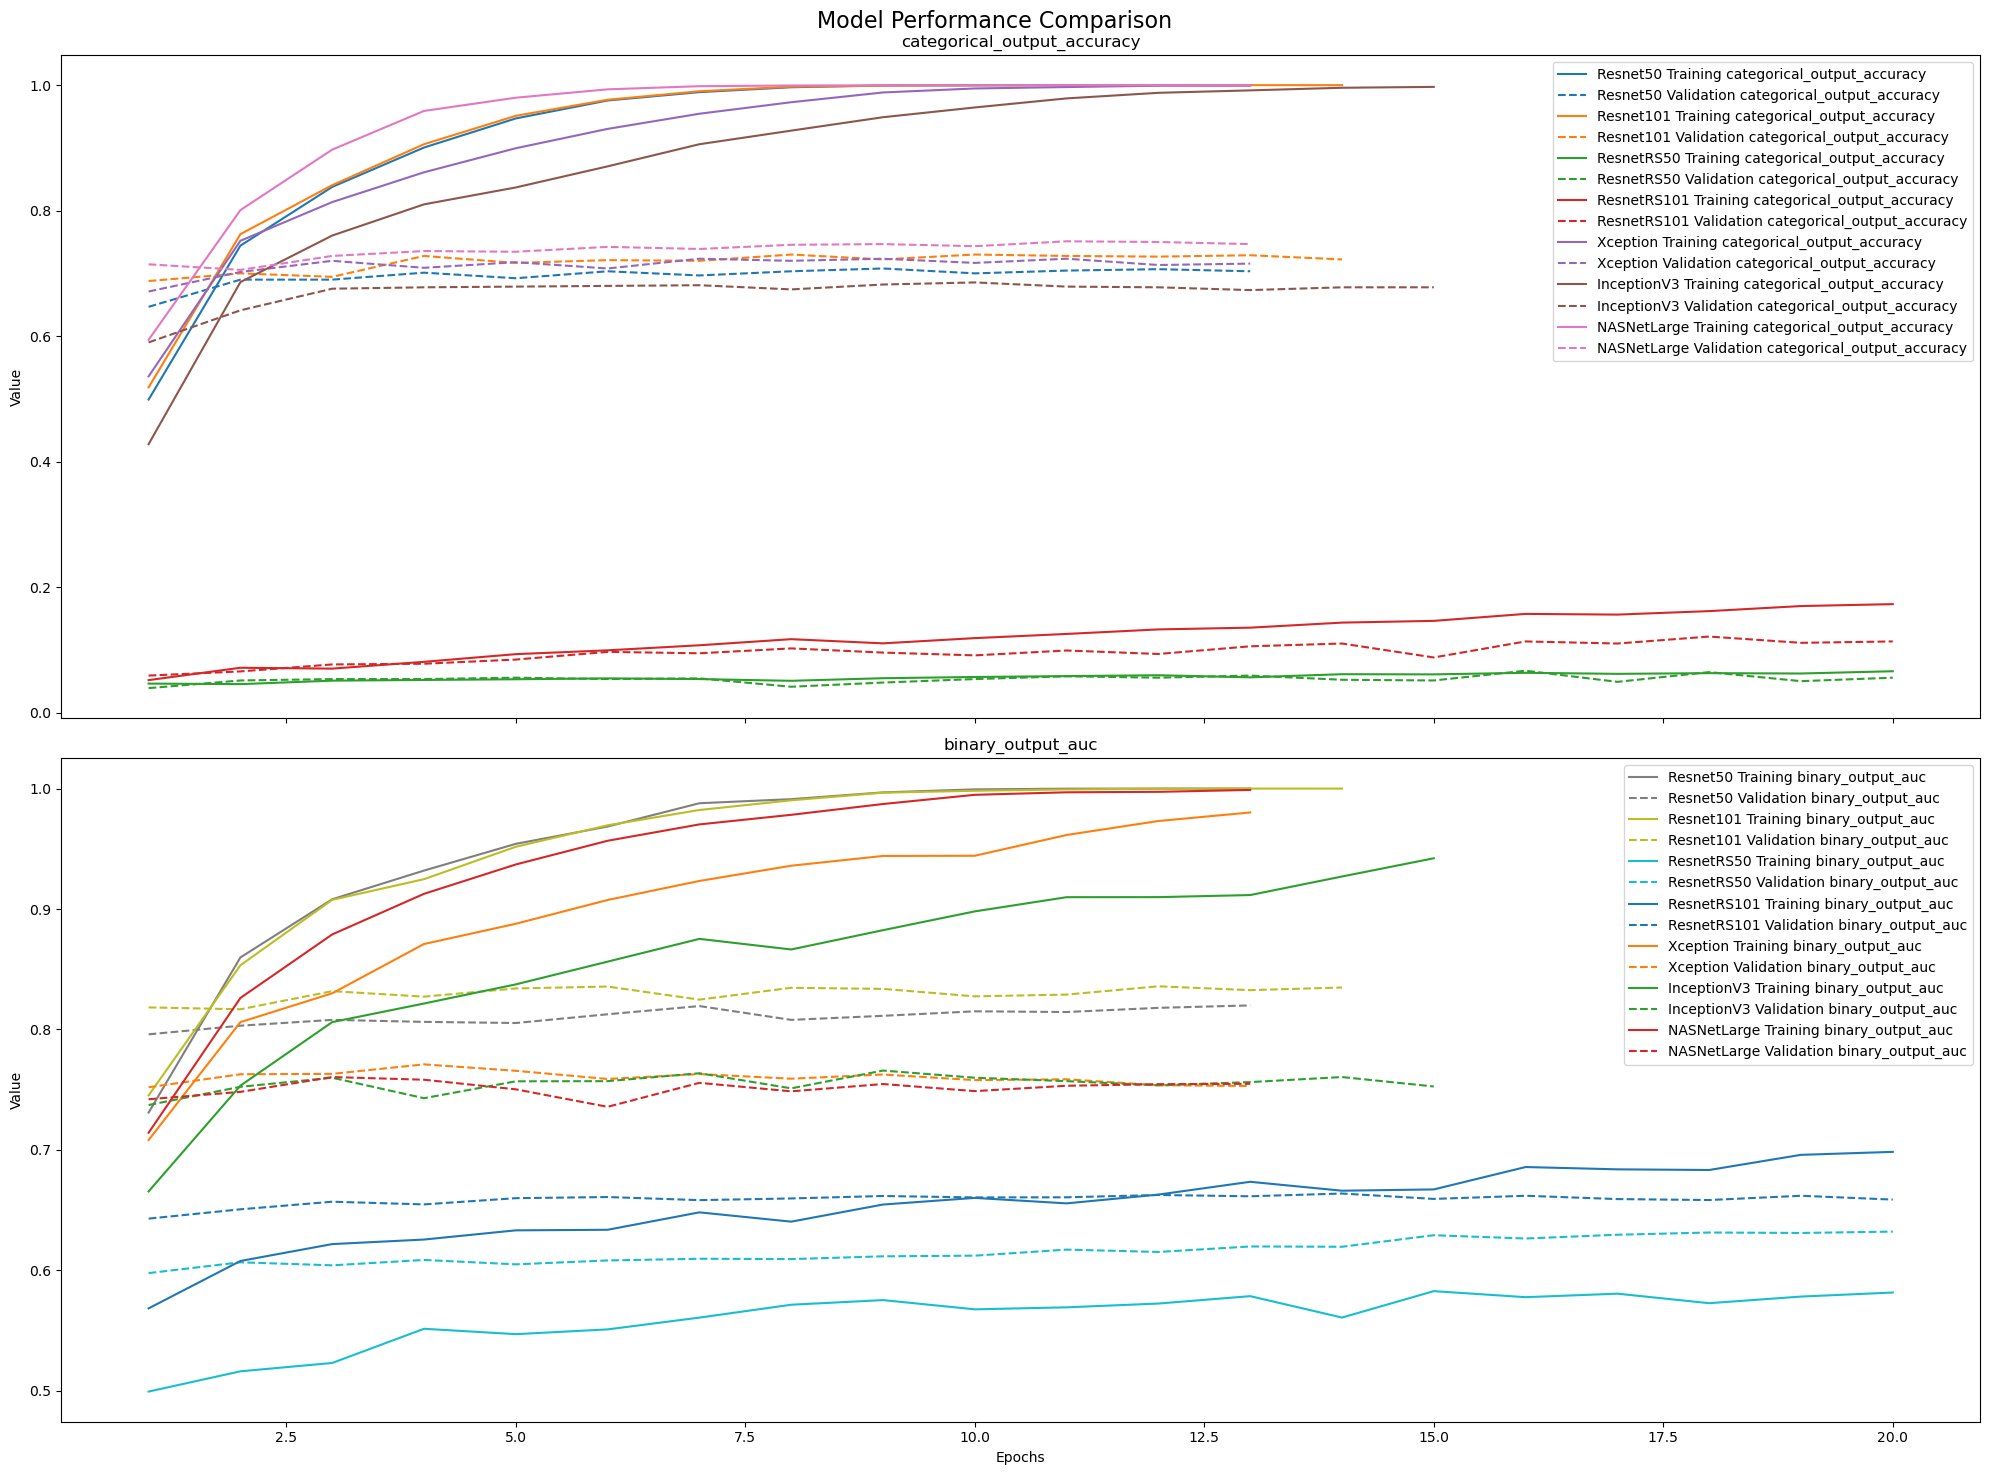

In [114]:
histories = [resnet50_history, resnet101_history, resnetRS50_history, resnetRS101_history, xception_history, inceptionV3_history, nasnet_history]
labels = ['Resnet50', 'Resnet101', 'ResnetRS50', 'ResnetRS101', 'Xception', 'InceptionV3', 'NASNetLarge']

plot_histories(histories, labels)

All the models tested showed signs of overfitting to the training data, but they performed better than our baseline model, as indicated by the higher validation accuracy—although some models, like ResNetRS50, didn't perform as well. This demonstrates that transfer learning effectively improved the model's performance. However, it's clear that different architectures yield different results. For the first output (categorical), NASNet achieved the highest accuracy, while for the second output (binary), ResNet101V2 had the best AUC. Based on these results, I'll choose NASNet or ResNet50V2, or a combination of both as the backbond model of the new design

#### Channel Attention Module / Spatial Attention Module

Despite implementing transfer learning, our model continues to suffer from overfitting. To further improve performance, we need to explore more advanced techniques to address this issue. One potential solution is to integrate attention mechanisms, such as the [Channel Attention Module](https://arxiv.org/abs/1807.06521v2), [Spatial Attention Module](https://arxiv.org/abs/1807.06521v2), or a combination of both (CBAM block).

The Channel Attention Module enhances important feature channels within a neural network by learning to prioritize the most relevant features for the task. Meanwhile, the Spatial Attention Module focuses on highlighting crucial spatial locations within the feature map, allowing the model to concentrate on significant areas of the input image. When combined, these attention modules improve the model's ability to extract and utilize essential information, leading to better performance in tasks like image classification and object detection.

The effectiveness of incorporating a Channel Attention Module has been demonstrated in several studies, including [this paper]((https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9765465)) and [this study](https://arxiv.org/pdf/2003.09893), which achieved noticeably higher accuracy. The key intuition is that the Channel Attention Module can adaptively weight the channels of feature maps generated by the CNN, selecting the most powerful features for use in the classification stage. This is particularly effective because the last layers of a CNN, which capture the global context of the image, contain class-specific information. By applying an attention mechanism on top of the CNN, the feature extraction process can yield more powerful and discriminative features, ultimately enhancing the model's performance in action classification.



##### Custom block implementations

During my research, I encountered various designs for channel attention modules and spatial attention modules, each offering unique approaches to enhancing feature representations in neural networks. I have implemented these designs in the following code blocks, with each function named according to the specific source from which it was derived. Below are the function names along with their corresponding sources:
- [channel_attention](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9765465)
- [spatial_attention](https://arxiv.org/abs/1807.06521)
- [cbam_block](https://arxiv.org/abs/1807.06521)

In this section, I will integrate the custom implementations of the attention modules into a model with NASNet as the backbone. I will then compare the performance of these different implementations. Based on the results, I will select the best-performing implementation and use it in future model designs.

In [30]:
def channel_attention(input_feature, ratio=8):
    channel = input_feature.shape[-1]
    
    shared_layer_one = layers.Dense(channel // ratio,
                                    kernel_initializer='he_normal',
                                    use_bias=True,
                                    bias_initializer='zeros')
    
    shared_layer_two = layers.Dense(channel,
                                    kernel_initializer='he_normal',
                                    use_bias=True,
                                    bias_initializer='zeros')
    
    # Reshape to fit Conv layers
    
    x = layers.GlobalAveragePooling2D()(input_feature)
    
    x = shared_layer_one(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = shared_layer_two(x)
    x = layers.Activation('relu')(x)
    
    return layers.Multiply()([input_feature, x])

In [31]:
def spatial_attention(input_feature):
    avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(input_feature)
    max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(input_feature)
    
    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    attention = layers.Conv2D(1, (7, 7), strides=1, padding='same', activation='sigmoid', 
                              kernel_initializer='he_normal', use_bias=False)(concat)
    
    return layers.Multiply()([input_feature, attention])

In [32]:
def cbam_block(input_feature, ratio=8):
    # Channel attention
    channel_att = channel_attention(input_feature, ratio)
    
    # Spatial attention
    spatial_att = spatial_attention(channel_att)
    
    return spatial_att

The new model design will incorporate the classification architecture and techniques from [this paper](https://arxiv.org/pdf/2003.09893) to further prevent overfitting, with modifications tailored to our specific task. Since our model needs to predict two outputs, unlike the single output task described in the paper, the classification section will be adapted to include separate output layers for each of these two outputs. This adjustment ensures that the model can effectively handle both the categorical and binary predictions required by our problem.

In [33]:
# Function to create model given attention module
def create_model_with_module(backbone, attention_module):
    base_model = backbone(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

    base_model.trainable = False

    input_layer = tf.keras.Input(shape=INPUT_SHAPE)

    x = base_model(input_layer, training=False)
    x = attention_module(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(128, activation='relu')(x)
    
    class_branch = layers.Dropout(0.4)(x)
    class_branch = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(class_branch)
    class_branch = layers.Dropout(0.4)(class_branch)
    class_branch = layers.Dense(32, activation='relu', kernel_initializer='he_normal')(class_branch)
    class_branch = layers.Dropout(0.4)(class_branch)
    class_branch = layers.Dense(40, activation='softmax', name='categorical_output')(class_branch)
    
    person_branch = layers.Dropout(0.4)(x)
    person_branch = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(person_branch)
    person_branch = layers.Dropout(0.4)(person_branch)
    person_branch = layers.Dense(32, activation='relu', kernel_initializer='he_normal')(person_branch)
    person_branch = layers.Dropout(0.4)(person_branch)
    person_branch = layers.Dense(1, activation='sigmoid', name='binary_output')(person_branch)
    
    model = models.Model(inputs=input_layer, outputs=[class_branch, person_branch])
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
    
    model.compile(optimizer=optimizer,
                loss={'categorical_output': 'sparse_categorical_crossentropy',
                        'binary_output': 'binary_crossentropy'},
                metrics={'categorical_output': 'accuracy',
                        'binary_output': tf.keras.metrics.AUC(name='auc')})

    return (model, base_model)

##### Channel attention module

In [37]:
design_1, design_1_base = create_model_with_module(tf.keras.applications.NASNetLarge, channel_attention)
design_1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 NASNet (Functional)            (None, 7, 7, 4032)   84916818    ['input_6[0][0]']                
                                                                                                  
 global_average_pooling2d_4 (Gl  (None, 4032)        0           ['NASNet[0][0]']                 
 obalAveragePooling2D)                                                                            
                                                                                            

In [38]:
design_1_history = design_1.fit(train_ds, epochs=20, callbacks=get_cbs(), validation_data=test_ds)

Epoch 1/20
113/113 [==============================] - 58s 407ms/step - loss: 4.6990 - categorical_output_loss: 3.8828 - binary_output_loss: 0.8162 - categorical_output_accuracy: 0.0236 - binary_output_auc: 0.5035 - val_loss: 4.3996 - val_categorical_output_loss: 3.7085 - val_binary_output_loss: 0.6911 - val_categorical_output_accuracy: 0.0267 - val_binary_output_auc: 0.5214
Epoch 2/20
113/113 [==============================] - 41s 365ms/step - loss: 4.5233 - categorical_output_loss: 3.7895 - binary_output_loss: 0.7338 - categorical_output_accuracy: 0.0283 - binary_output_auc: 0.5172 - val_loss: 4.3599 - val_categorical_output_loss: 3.6840 - val_binary_output_loss: 0.6759 - val_categorical_output_accuracy: 0.0389 - val_binary_output_auc: 0.5352
Epoch 3/20
113/113 [==============================] - 41s 365ms/step - loss: 4.4636 - categorical_output_loss: 3.7494 - binary_output_loss: 0.7142 - categorical_output_accuracy: 0.0314 - binary_output_auc: 0.5243 - val_loss: 4.3336 - val_categori

##### Spatial attention

In [41]:
design_2, design_2_base = create_model_with_module(tf.keras.applications.NASNetLarge, spatial_attention)
design_2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 NASNet (Functional)            (None, 7, 7, 4032)   84916818    ['input_8[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 7, 7, 1)      0           ['NASNet[0][0]']                 
                                                                                                  
 lambda_1 (Lambda)              (None, 7, 7, 1)      0           ['NASNet[0][0]']           

In [42]:
design_2_history = design_2.fit(train_ds, epochs=20, callbacks=get_cbs(), validation_data=test_ds)

Epoch 1/20
113/113 [==============================] - 72s 435ms/step - loss: 4.5005 - categorical_output_loss: 3.7986 - binary_output_loss: 0.7019 - categorical_output_accuracy: 0.0297 - binary_output_auc: 0.4966 - val_loss: 4.3759 - val_categorical_output_loss: 3.6921 - val_binary_output_loss: 0.6839 - val_categorical_output_accuracy: 0.0300 - val_binary_output_auc: 0.4983
Epoch 2/20
113/113 [==============================] - 43s 374ms/step - loss: 4.3789 - categorical_output_loss: 3.6952 - binary_output_loss: 0.6838 - categorical_output_accuracy: 0.0272 - binary_output_auc: 0.5047 - val_loss: 4.3722 - val_categorical_output_loss: 3.6888 - val_binary_output_loss: 0.6834 - val_categorical_output_accuracy: 0.0300 - val_binary_output_auc: 0.4928
Epoch 3/20
113/113 [==============================] - 43s 374ms/step - loss: 4.3744 - categorical_output_loss: 3.6913 - binary_output_loss: 0.6830 - categorical_output_accuracy: 0.0300 - binary_output_auc: 0.5041 - val_loss: 4.3687 - val_categori

##### Cbam

In [47]:
design_3, design_3_base = create_model_with_module(tf.keras.applications.NASNetLarge, cbam_block)
design_3.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 NASNet (Functional)            (None, 7, 7, 4032)   84916818    ['input_12[0][0]']               
                                                                                                  
 global_average_pooling2d_7 (Gl  (None, 4032)        0           ['NASNet[0][0]']                 
 obalAveragePooling2D)                                                                            
                                                                                            

In [48]:
design_3_history = design_3.fit(train_ds, epochs=20, callbacks=get_cbs(), validation_data=test_ds)

Epoch 1/20
113/113 [==============================] - 71s 485ms/step - loss: 4.3856 - categorical_output_loss: 3.7011 - binary_output_loss: 0.6845 - categorical_output_accuracy: 0.0289 - binary_output_auc: 0.4788 - val_loss: 4.3749 - val_categorical_output_loss: 3.6914 - val_binary_output_loss: 0.6835 - val_categorical_output_accuracy: 0.0189 - val_binary_output_auc: 0.4903
Epoch 2/20
113/113 [==============================] - 43s 379ms/step - loss: 4.3774 - categorical_output_loss: 3.6948 - binary_output_loss: 0.6826 - categorical_output_accuracy: 0.0244 - binary_output_auc: 0.4817 - val_loss: 4.3711 - val_categorical_output_loss: 3.6903 - val_binary_output_loss: 0.6807 - val_categorical_output_accuracy: 0.0233 - val_binary_output_auc: 0.4879
Epoch 3/20
113/113 [==============================] - 43s 379ms/step - loss: 4.3721 - categorical_output_loss: 3.6929 - binary_output_loss: 0.6792 - categorical_output_accuracy: 0.0317 - binary_output_auc: 0.4928 - val_loss: 4.3674 - val_categori

##### Compare modules

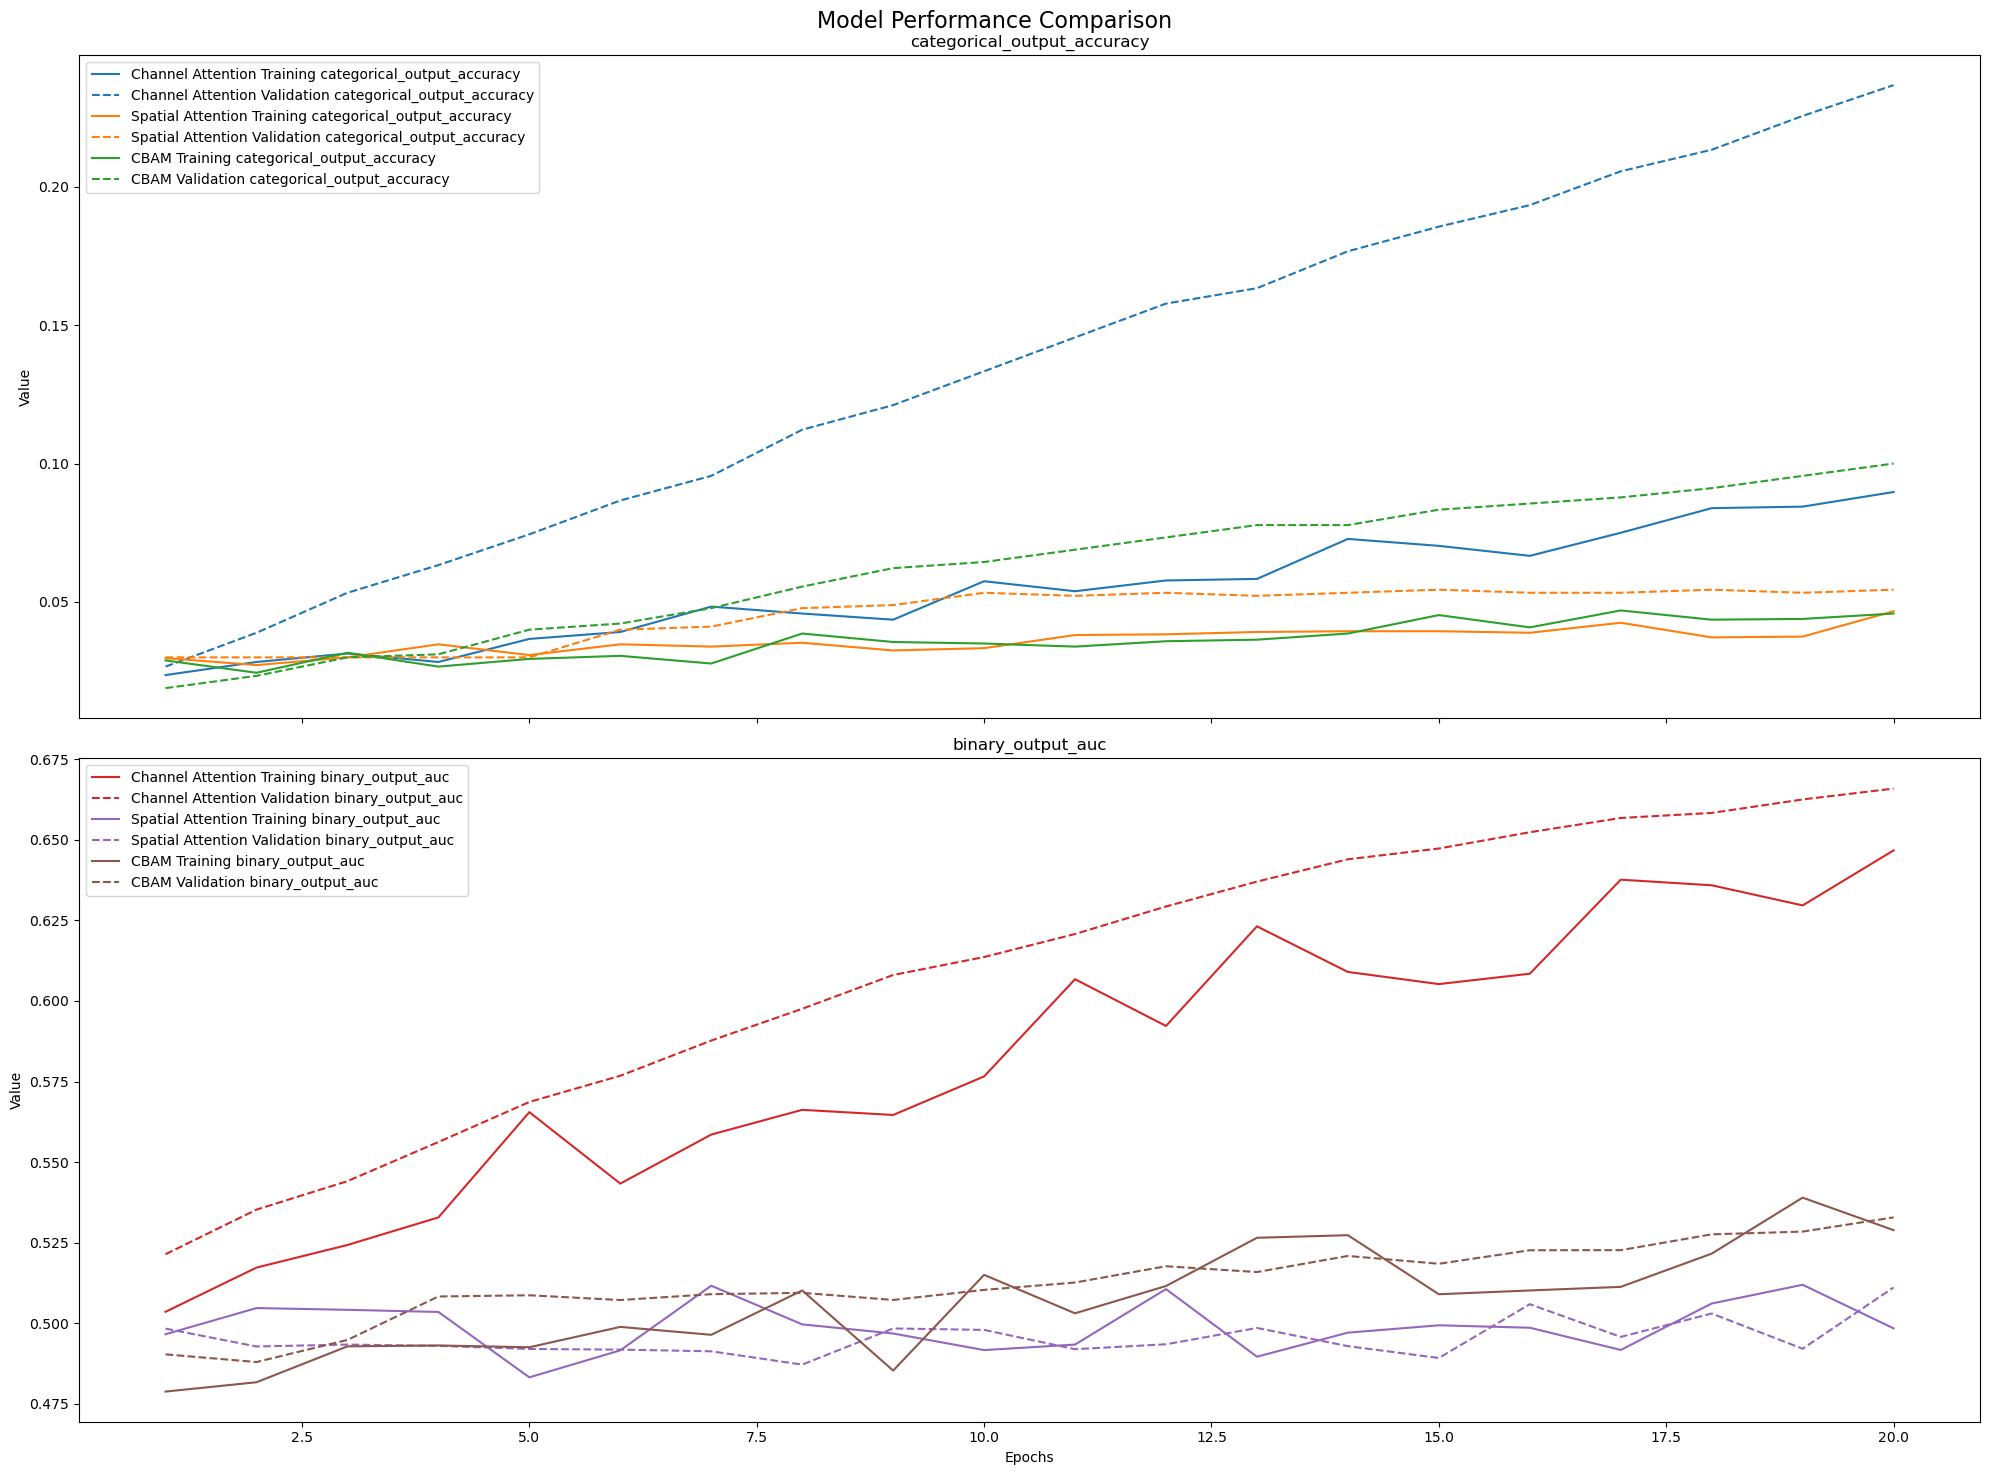

In [49]:
histories = [design_1_history, design_2_history, design_3_history]
labels = ['Channel Attention', 'Spatial Attention', 'CBAM']

plot_histories(histories, labels)

The results clearly show that the channel attention module outperforms other modules when using the same model setup. Given its superior performance, we will choose the channel attention module for our final model configuration to help enhance feature extraction and improve overall accuracy.

#### Separate branch

During training with the current model architecture, I noticed a pattern: while the categorical accuracy improved, the binary accuracy eventually plateaued and stopped improving, even as the categorical accuracy continued to rise. This suggests that the binary output was overfitting. I believe this is because both outputs share the same channel attention module, forcing it to select features relevant to both tasks. However, since the categorical and binary outputs are somewhat different, they may require distinct sets of features, making it difficult for the shared module to choose features that are optimal for both outputs.

To address the issue, my solution is to assign a separate attention module to each output branch or even give each branch its own backbone model. This approach allows each branch to focus on selecting the most relevant features for its specific task, which should improve the performance of both outputs. Alternatively, by using a different backbone model for each branch, we can ensure that each output has its own dedicated feature extraction process, better suited to its unique requirements. This separation should help avoid the conflicts that arise when the branches share feature extraction layers, ultimately improving the overall model performance.

This idea was inspired by [End-to-End Multi-Task Learning with Attention](https://arxiv.org/abs/1803.10704), which highlights the effectiveness of using independent attention mechanisms for different tasks in multi-task learning.

##### Separate module for each outputs

In [37]:
def create_model_separate_module(backbone):
    base_model = backbone(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

    base_model.trainable = False

    input_layer = tf.keras.Input(shape=INPUT_SHAPE)

    x = base_model(input_layer, training=False)
    
    class_branch = channel_attention(x)
    class_branch = layers.GlobalAveragePooling2D()(class_branch)
    class_branch = layers.Dropout(0.4)(class_branch)
    class_branch = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(class_branch)
    class_branch = layers.Dropout(0.4)(class_branch)
    class_branch = layers.Dense(32, activation='relu', kernel_initializer='he_normal')(class_branch)
    class_branch = layers.Dropout(0.4)(class_branch)
    class_branch = layers.Dense(40, activation='softmax', name='categorical_output')(class_branch)
    
    person_branch = channel_attention(x)
    person_branch = layers.GlobalAveragePooling2D()(person_branch)
    person_branch = layers.Dropout(0.4)(person_branch)
    person_branch = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(person_branch)
    person_branch = layers.Dropout(0.4)(person_branch)
    person_branch = layers.Dense(32, activation='relu', kernel_initializer='he_normal')(person_branch)
    person_branch = layers.Dropout(0.4)(person_branch)
    person_branch = layers.Dense(1, activation='sigmoid', name='binary_output')(person_branch)
    
    model = models.Model(inputs=input_layer, outputs=[class_branch, person_branch])
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
    
    model.compile(optimizer=optimizer,
                loss={'categorical_output': 'sparse_categorical_crossentropy',
                        'binary_output': 'binary_crossentropy'},
                metrics={'categorical_output': 'accuracy',
                        'binary_output': tf.keras.metrics.AUC(name='auc')})

    return (model, base_model)

In [38]:
design_4, design_4_base = create_model_separate_module(tf.keras.applications.NASNetLarge)
design_4.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 NASNet (Functional)            (None, 7, 7, 4032)   84916818    ['input_4[0][0]']                
                                                                                                  
 global_average_pooling2d_4 (Gl  (None, 4032)        0           ['NASNet[0][0]']                 
 obalAveragePooling2D)                                                                            
                                                                                            

In [39]:
design_4_history = design_4.fit(train_ds, epochs=100, callbacks=get_cbs(), validation_data=test_ds)

Epoch 1/100
113/113 [==============================] - 67s 415ms/step - loss: 4.6996 - categorical_output_loss: 3.8689 - binary_output_loss: 0.8307 - categorical_output_accuracy: 0.0211 - binary_output_auc: 0.4957 - val_loss: 4.3655 - val_categorical_output_loss: 3.6807 - val_binary_output_loss: 0.6848 - val_categorical_output_accuracy: 0.0211 - val_binary_output_auc: 0.5203
Epoch 2/100
113/113 [==============================] - 42s 368ms/step - loss: 4.5288 - categorical_output_loss: 3.7897 - binary_output_loss: 0.7391 - categorical_output_accuracy: 0.0253 - binary_output_auc: 0.5124 - val_loss: 4.3113 - val_categorical_output_loss: 3.6500 - val_binary_output_loss: 0.6613 - val_categorical_output_accuracy: 0.0378 - val_binary_output_auc: 0.5359
Epoch 3/100
113/113 [==============================] - 41s 365ms/step - loss: 4.4516 - categorical_output_loss: 3.7311 - binary_output_loss: 0.7205 - categorical_output_accuracy: 0.0317 - binary_output_auc: 0.5128 - val_loss: 4.2818 - val_categ

##### Separate backbone models for each output

For the second output, I chose a smaller, more lightweight model to reduce the overall number of parameters and make the model more efficient. I chose MobileNetV2 for this task because it is designed to be computationally efficient while still providing strong performance, making it a good fit for reducing the complexity without sacrificing accuracy. This approach helps balance the model's size and effectiveness, especially for tasks where fewer features are needed for accurate predictions.

In [42]:
def create_model_separate_backbone(backbones):
    base_model_cat = backbones[0](weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
    base_model_cat.trainable = False

    # Second pre-trained model (MobileNetV2) for the binary output
    base_model_bin = backbones[1](weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
    base_model_bin.trainable = False

    input_layer = tf.keras.Input(shape=INPUT_SHAPE)
    
    x = base_model_cat(input_layer, training=False)
    x = channel_attention(x)
    x = layers.GlobalAveragePooling2D()(x)
    
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(64, kernel_initializer='he_normal', activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(32, kernel_initializer='he_normal', activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    class_output = layers.Dense(40, activation='softmax', name='categorical_output')(x)
    
    y = base_model_bin(input_layer, training=False)
    y = layers.GlobalAveragePooling2D()(y)
    
    y = layers.Dropout(0.4)(y)
    y = layers.Dense(64, kernel_initializer='he_normal', activation='relu')(y)
    y = layers.Dropout(0.4)(y)
    y = layers.Dense(32, kernel_initializer='he_normal', activation='relu')(y)
    y = layers.Dropout(0.4)(y)
    binary_output = layers.Dense(1, activation='sigmoid', name='binary_output')(y)
    
    model = models.Model(inputs=input_layer, outputs=[class_output, binary_output])
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
    
    model.compile(optimizer=optimizer,
                loss={'categorical_output': 'sparse_categorical_crossentropy',
                        'binary_output': 'binary_crossentropy'},
                metrics={'categorical_output': 'accuracy',
                        'binary_output': tf.keras.metrics.AUC(name='auc')})

    return (model, base_model_cat, base_model_bin)

In [45]:
design_5, design_5_cat_base, design_5_bin_base = create_model_separate_backbone([tf.keras.applications.NASNetLarge, tf.keras.applications.MobileNetV2])
design_5.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 NASNet (Functional)            (None, 7, 7, 4032)   84916818    ['input_10[0][0]']               
                                                                                                  
 global_average_pooling2d_11 (G  (None, 4032)        0           ['NASNet[0][0]']                 
 lobalAveragePooling2D)                                                                           
                                                                                            

In [46]:
design_5_history = design_5.fit(train_ds, epochs=100, callbacks=get_cbs(), validation_data=test_ds)

Epoch 1/100
113/113 [==============================] - 67s 461ms/step - loss: 4.4853 - categorical_output_loss: 3.6913 - binary_output_loss: 0.7940 - categorical_output_accuracy: 0.0525 - binary_output_auc: 0.5149 - val_loss: 4.1527 - val_categorical_output_loss: 3.5105 - val_binary_output_loss: 0.6422 - val_categorical_output_accuracy: 0.2311 - val_binary_output_auc: 0.6591
Epoch 2/100
113/113 [==============================] - 46s 409ms/step - loss: 4.0904 - categorical_output_loss: 3.4197 - binary_output_loss: 0.6707 - categorical_output_accuracy: 0.1122 - binary_output_auc: 0.5777 - val_loss: 3.7882 - val_categorical_output_loss: 3.1566 - val_binary_output_loss: 0.6317 - val_categorical_output_accuracy: 0.3489 - val_binary_output_auc: 0.7014
Epoch 3/100
113/113 [==============================] - 46s 409ms/step - loss: 3.8122 - categorical_output_loss: 3.1541 - binary_output_loss: 0.6581 - categorical_output_accuracy: 0.1822 - binary_output_auc: 0.5950 - val_loss: 3.3863 - val_categ

##### Compare

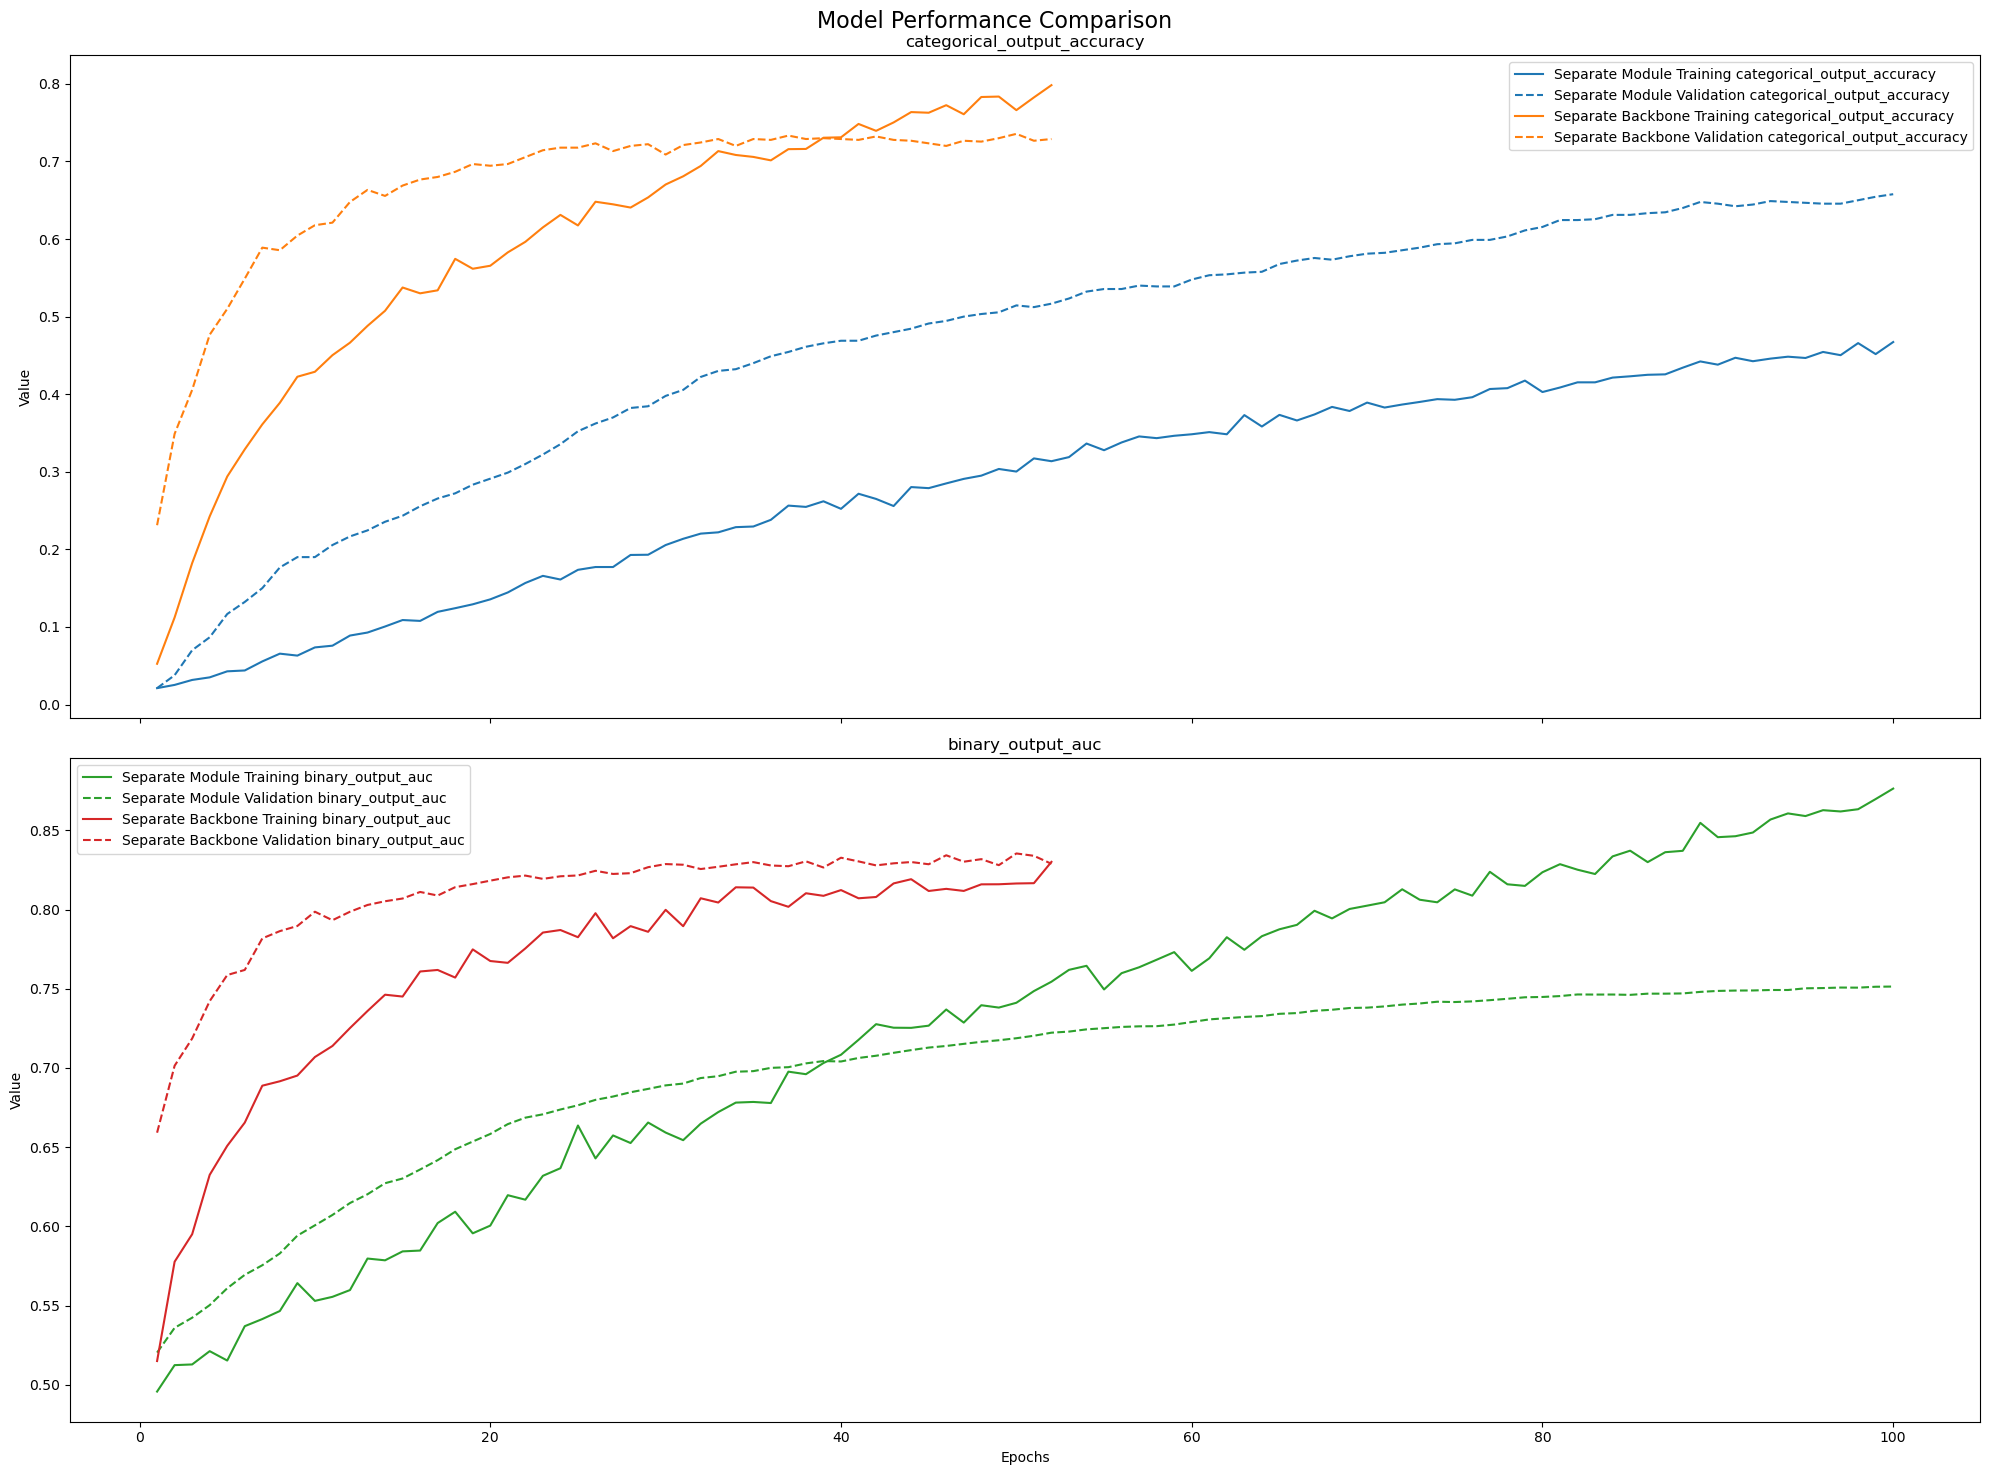

In [50]:
histories = [design_4_history, design_5_history]
labels = ['Separate Module', 'Separate Backbone']

plot_histories(histories, labels)

By using separate backbone models for each branch, we saw a clear improvement in performance, with the model achieving better results in fewer epochs. This suggests that having dedicated backbone models for each output allows the model to focus on more relevant features for each task. As a result, I will use separate backbone models for each output in the final setup to maximize performance. However, we can see that the model is slightly overfitting, as shown by the lower validation accuracy. Thus, in the next step, we will apply well-known techniques to reduce the overfitting such as:
- Data Augmentation
- Reducing model complexity
- l2 regularization
- Modify Dropout value

#### Data Augmentation

I applied horizontal flipping, random brightness and contrast to augment the data

##### Prepare data

In [72]:
# Loading images and shuffling datasets
aug_ds = tf.data.Dataset.from_tensor_slices((train['FilePath'], {'categorical_output': train['Class'], 'binary_output': train['MoreThanOnePerson']}))
aug_ds = aug_ds.map(lambda x, y: load_image(x, y, augment=True)).shuffle(1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test['FilePath'], {'categorical_output': test['Class'], 'binary_output': test['MoreThanOnePerson']}))
test_ds = test_ds.map(lambda x, y: load_image(x, y)).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

future_ds = tf.data.Dataset.from_tensor_slices((future_data['FilePath']))
future_ds = future_ds.map(lambda x: load_image(x, None)).shuffle(1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

(32, 224, 224, 3)
(32,)
(32,)


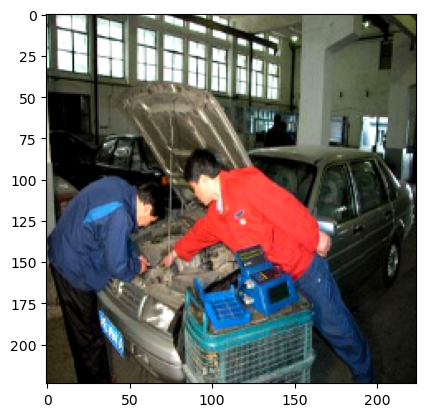

In [75]:
for image, label in aug_ds.take(1):
    print(image.shape)
    print(label['categorical_output'].shape)
    print(label['binary_output'].shape)
    plt.imshow(image[0])

##### Train model on augmented data

In [71]:
design_5_aug, design_5_cat_base_aug, design_5_bin_base_aug = create_model_separate_backbone([tf.keras.applications.NASNetLarge, tf.keras.applications.MobileNetV2])

In [76]:
design_5_aug_history = design_5_aug.fit(aug_ds, epochs=100, callbacks=get_cbs(), validation_data=test_ds)

Epoch 1/100
113/113 [==============================] - 77s 473ms/step - loss: 4.4617 - categorical_output_loss: 3.7342 - binary_output_loss: 0.7274 - categorical_output_accuracy: 0.0447 - binary_output_auc: 0.5454 - val_loss: 4.2096 - val_categorical_output_loss: 3.5626 - val_binary_output_loss: 0.6470 - val_categorical_output_accuracy: 0.1756 - val_binary_output_auc: 0.6304
Epoch 2/100
113/113 [==============================] - 49s 406ms/step - loss: 4.1518 - categorical_output_loss: 3.4707 - binary_output_loss: 0.6811 - categorical_output_accuracy: 0.1072 - binary_output_auc: 0.5472 - val_loss: 3.8620 - val_categorical_output_loss: 3.2178 - val_binary_output_loss: 0.6442 - val_categorical_output_accuracy: 0.2744 - val_binary_output_auc: 0.6548
Epoch 3/100
113/113 [==============================] - 48s 405ms/step - loss: 3.8975 - categorical_output_loss: 3.2384 - binary_output_loss: 0.6592 - categorical_output_accuracy: 0.1550 - binary_output_auc: 0.5783 - val_loss: 3.5565 - val_categ

##### Adding l2 regularization and reducing model complexity